In [ ]:
pip install tableone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statistics

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score

from imblearn.over_sampling import SMOTE

from tableone import TableOne

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Updated Files - Jan 2025/diabetes_only.csv").drop(["Unnamed: 0"], axis = 1)
data.shape

<ipython-input-4-718af5386738>:1: DtypeWarning: Columns (36,58,60,64,66,68,78,84,96,102) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/Updated Files - Jan 2025/diabetes_only.csv").drop(["Unnamed: 0"], axis = 1)


(23970, 175)

# Data Preprocessing


1.   Assess class imbalance in categorical variables
2.   Assess distributional skew and presence of outliers/biologically implausible values in continuous variables
3. Assess potential collinearity
4. Assess nature of missing data using barplots



# of depression diagnoses w/o date: 0
# of diabetes diagnoses w/o date: 0
# of diabetes diagnoses after depression date: 0


Class imbalance
Depression
0    0.865457
1    0.134543
Name: proportion, dtype: float64




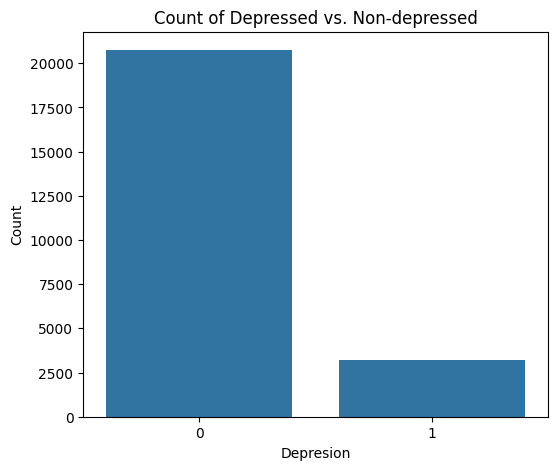

In [ ]:
### Results of subset dataset that removes records with:
#### (1) no date for diabetes and/or;
#### (2) depression diagnoses or a depression diagnosis date preceding the diabetes diagnosis date were dropped

print(f"# of depression diagnoses w/o date: {len(data[(data.Depression == 1) & (data.Depression_OnsetDate.isnull())])}")
print(f"# of diabetes diagnoses w/o date: {len(data[(data.Diabetes == 1) & (data.DM_OnsetDate.isnull())])}")
print(f"# of diabetes diagnoses after depression date: {len(data[(data.Depression == 1) & (data.DM_OnsetDate > data.Depression_OnsetDate)])}")

### Checking class imbalance
print("\n\nClass imbalance")
print(data["Depression"].value_counts(normalize=True))
print("\n")

plt.figure(figsize = (6, 5))
sns.countplot(data = data, x = "Depression")

plt.xlabel("Depresion")
plt.ylabel("Count")
plt.title("Count of Depressed vs. Non-depressed")
plt.show()

## Selecting features for inclusion

In [ ]:
### List of features selected for inclusion based on literature review

df = data[["Depression", "[Depression_Date]", "Age_at_Exam", "BMI", "Sex", "A1c",
           "b_R1_sleep", "b_R1_kidney", "b_R1_heart", "b_R1_brain", "b_R1_eye",
           "[PVD)", "[Neuropathy)", "[Nephropathy)", "[Amputation)", "[Dialysis)",
           "[PeritonealDialysis)", "[Proteinuria)", "[Cardiomyopathy)", "[Anxiety)",
           "[Anxiety_Date]", "[Blindness)", "[Retinopathy)", "[RetinalTear)",
           "total_b_R1_[1stlineantidiabetic]_Records",
           "total_b_R1_[2ndline-antidiabetic]_Records"]]

print(f"Dimensions of dataset: {df.shape}")

description = df.describe()
description

Dimensions of dataset: (23970, 26)


,Depression,Age_at_Exam,BMI,A1c,b_R1_sleep,b_R1_kidney,b_R1_heart,b_R1_brain,b_R1_eye,[PVD),...,[Dialysis),[PeritonealDialysis),[Proteinuria),[Cardiomyopathy),[Anxiety),[Blindness),[Retinopathy),[RetinalTear),total_b_R1_[1stlineantidiabetic]_Records,total_b_R1_[2ndline-antidiabetic]_Records
count,23970.000000,23970.000000,23970.000000,19859.000000,23970.000000,23970.000000,23970.000000,23970.000000,23970.000000,2495.000000,...,2495.000000,2495.0,2495.000000,2495.000000,2495.000000,2495.000000,2495.000000,2495.000000,13134.000000,6449.000000
mean,0.134543,64.158156,31.639858,6.886605,0.018064,0.013976,0.052065,0.015019,0.023988,0.040882,...,0.002806,0.0,0.018437,0.009218,0.240080,0.007214,0.010822,0.001603,6.783843,7.472476
std,0.341242,13.405684,7.816554,1.191315,0.133187,0.117393,0.222163,0.121630,0.153016,0.198056,...,0.052904,0.0,0.134552,0.095588,0.427218,0.084648,0.103483,0.040016,6.953475,8.041720
min,0.000000,18.000000,5.100000,0.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,55.000000,26.800000,6.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000
50%,0.000000,65.000000,30.413898,6.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000
75%,0.000000,74.000000,35.000000,7.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,10.000000
max,1.000000,90.000000,239.200000,16.400000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,86.000000,86.000000


In [ ]:
columns = list(df.columns)
dates = ["[Anxiety_Date]", "[Depression_Date]"]
cont_columns = ["A1c", "total_b_R1_[1stlineantidiabetic]_Records", "total_b_R1_[2ndline-antidiabetic]_Records", "Age_at_Exam", "BMI"]
cat_columns = [c for c in columns if c not in cont_columns + dates]

## Exploratory analysis: categorical variables
"[PeritonealDialysis)" removed because instances of 1

In [ ]:
def assess_categorical(df, col):
  print(f"Column: {col}\n")
  print(df[col].value_counts(normalize = True)*100)

  plt.figure(figsize=(10, 5))
  sns.countplot(x = df[col])
  plt.xlabel(col)
  plt.ylabel('Count')
  plt.title(f'Count of {col}')
  plt.show()

  print("\n")

=====Depression=====
Column: Depression

Depression
0    86.545682
1    13.454318
Name: proportion, dtype: float64


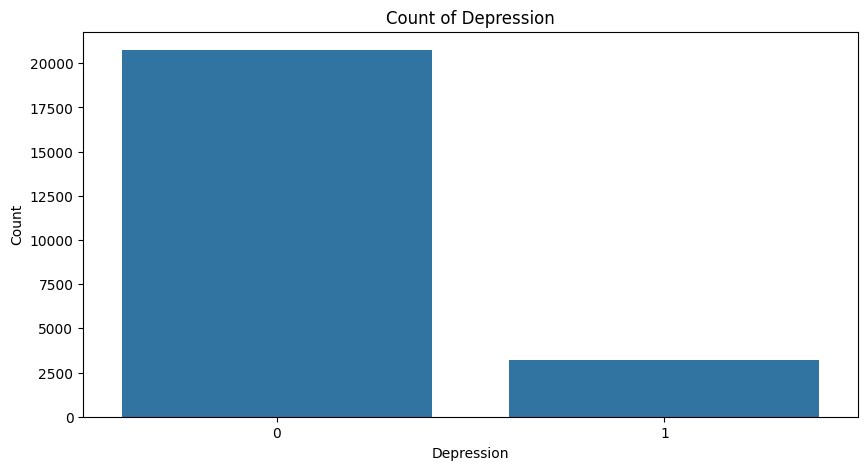



=====Sex=====
Column: Sex

Sex
Male      52.436379
Female    47.563621
Name: proportion, dtype: float64


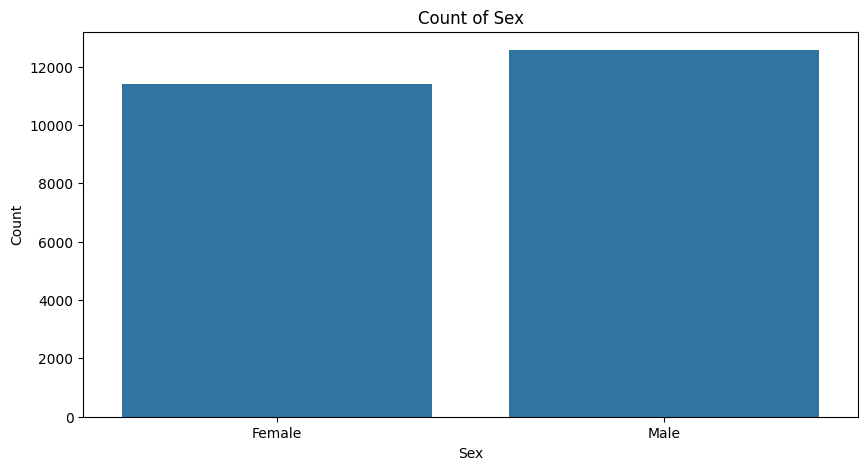



=====b_R1_sleep=====
Column: b_R1_sleep

b_R1_sleep
0    98.193575
1     1.806425
Name: proportion, dtype: float64


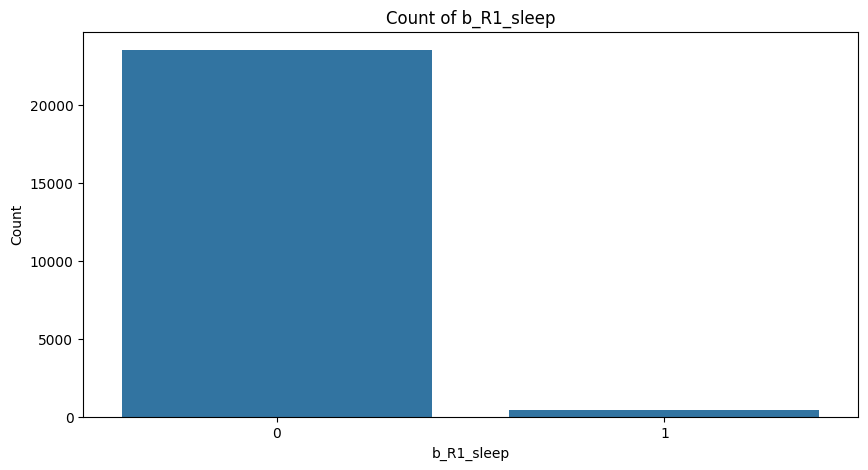



=====b_R1_kidney=====
Column: b_R1_kidney

b_R1_kidney
0    98.60242
1     1.39758
Name: proportion, dtype: float64


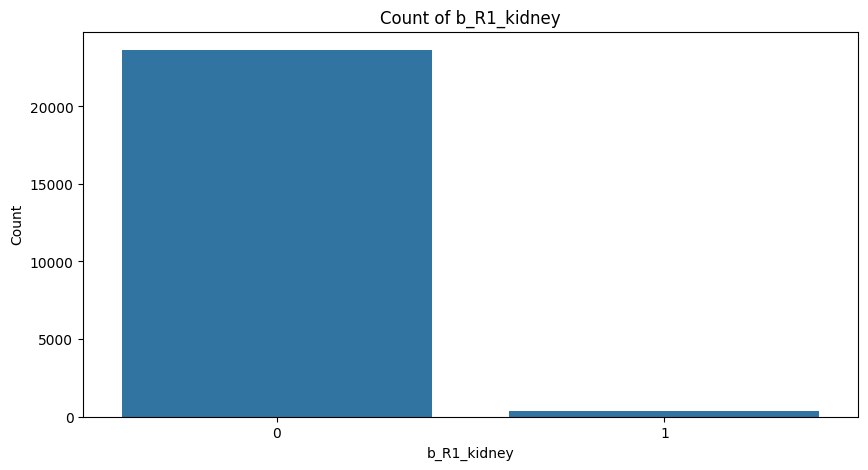



=====b_R1_heart=====
Column: b_R1_heart

b_R1_heart
0    94.793492
1     5.206508
Name: proportion, dtype: float64


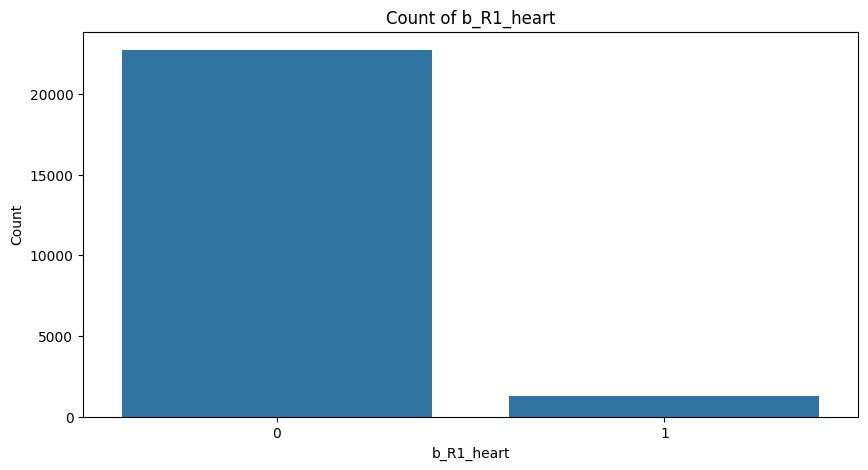



=====b_R1_brain=====
Column: b_R1_brain

b_R1_brain
0    98.498123
1     1.501877
Name: proportion, dtype: float64


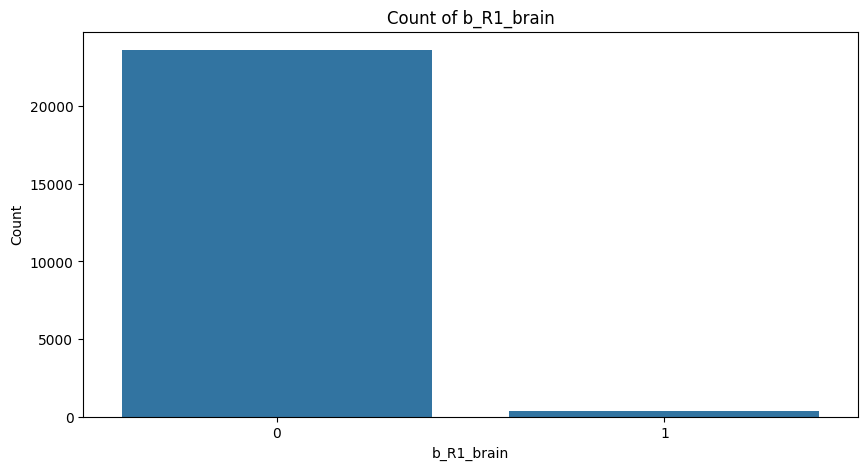



=====b_R1_eye=====
Column: b_R1_eye

b_R1_eye
0    97.601168
1     2.398832
Name: proportion, dtype: float64


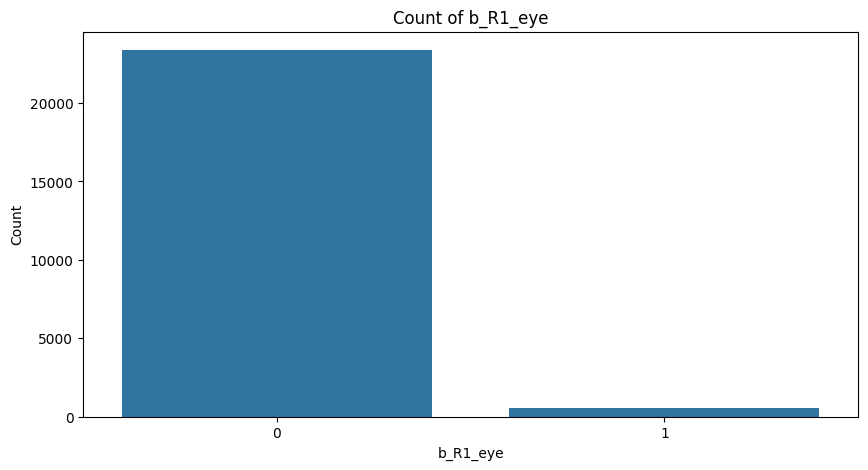



=====[PVD)=====
Column: [PVD)

[PVD)
0.0    95.911824
1.0     4.088176
Name: proportion, dtype: float64


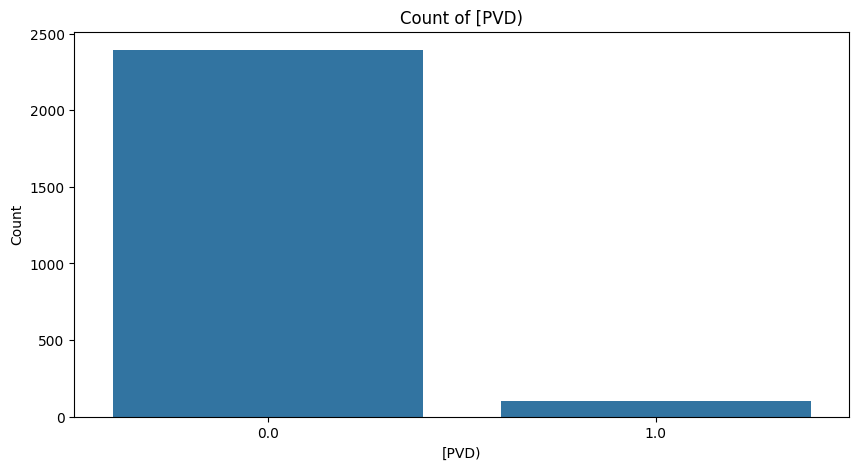



=====[Neuropathy)=====
Column: [Neuropathy)

[Neuropathy)
0.0    93.226453
1.0     6.773547
Name: proportion, dtype: float64


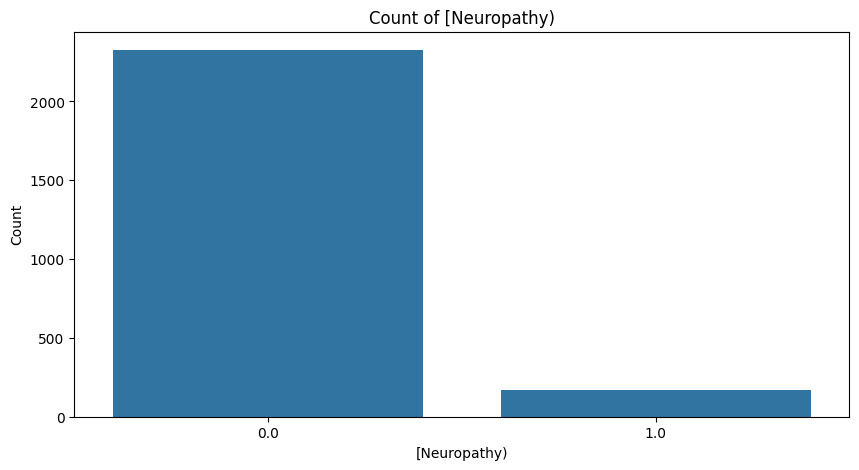



=====[Nephropathy)=====
Column: [Nephropathy)

[Nephropathy)
0.0    98.997996
1.0     1.002004
Name: proportion, dtype: float64


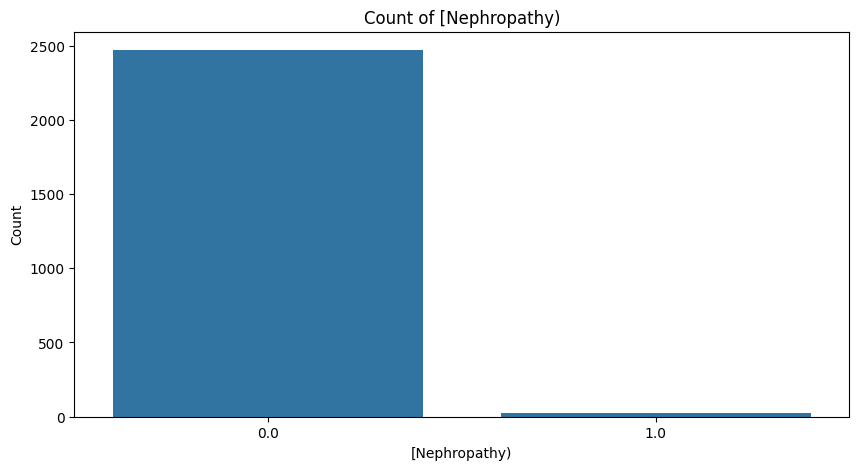



=====[Amputation)=====
Column: [Amputation)

[Amputation)
0.0    98.517034
1.0     1.482966
Name: proportion, dtype: float64


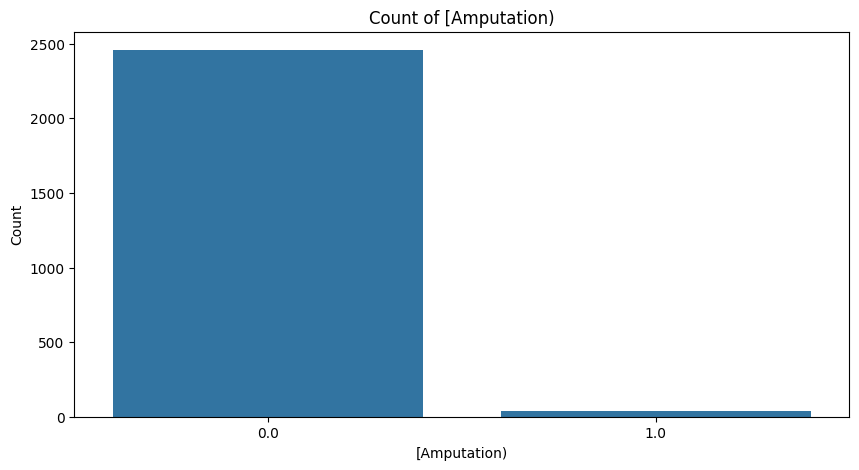



=====[Dialysis)=====
Column: [Dialysis)

[Dialysis)
0.0    99.719439
1.0     0.280561
Name: proportion, dtype: float64


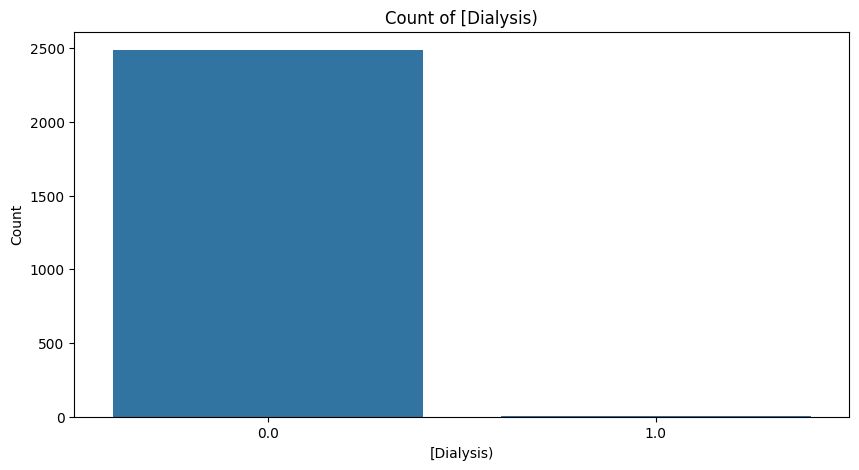



=====[PeritonealDialysis)=====
Column: [PeritonealDialysis)

[PeritonealDialysis)
0.0    100.0
Name: proportion, dtype: float64


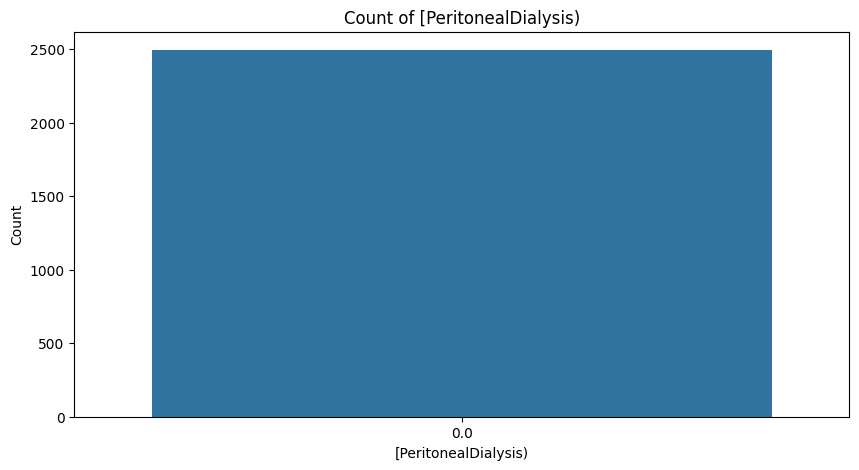



=====[Proteinuria)=====
Column: [Proteinuria)

[Proteinuria)
0.0    98.156313
1.0     1.843687
Name: proportion, dtype: float64


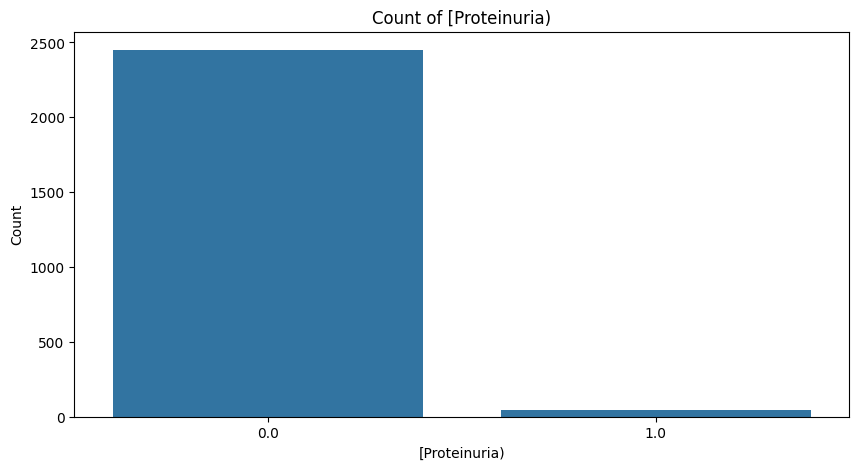



=====[Cardiomyopathy)=====
Column: [Cardiomyopathy)

[Cardiomyopathy)
0.0    99.078156
1.0     0.921844
Name: proportion, dtype: float64


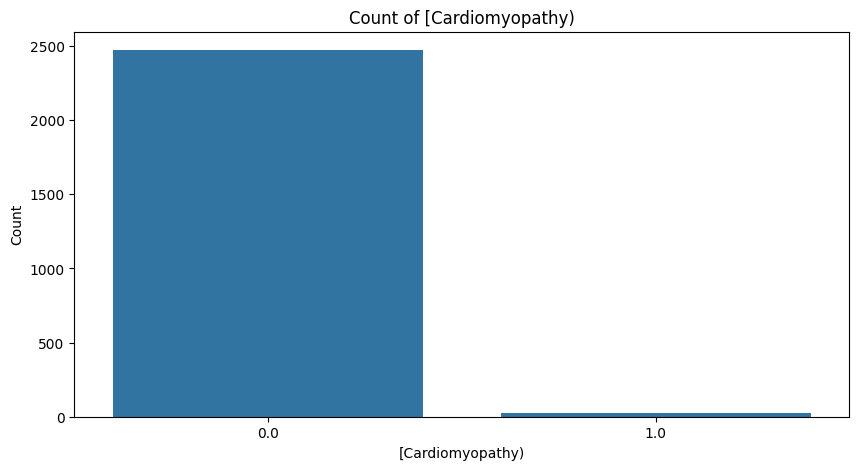



=====[Anxiety)=====
Column: [Anxiety)

[Anxiety)
0.0    75.991984
1.0    24.008016
Name: proportion, dtype: float64


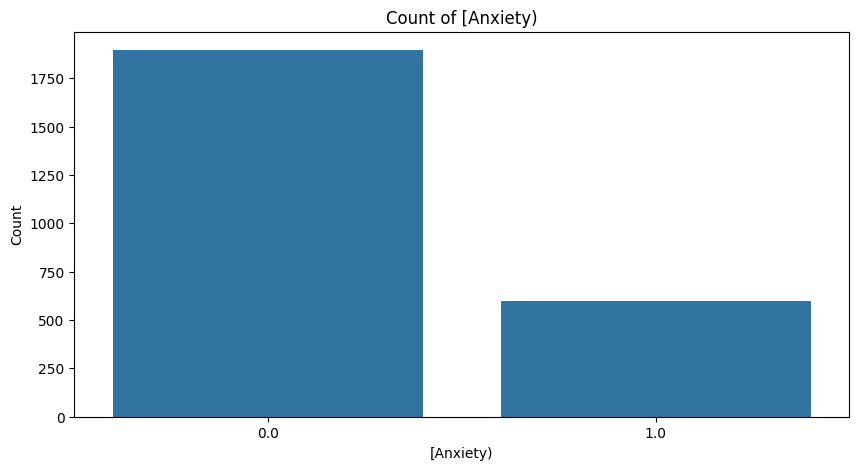



=====[Blindness)=====
Column: [Blindness)

[Blindness)
0.0    99.278557
1.0     0.721443
Name: proportion, dtype: float64


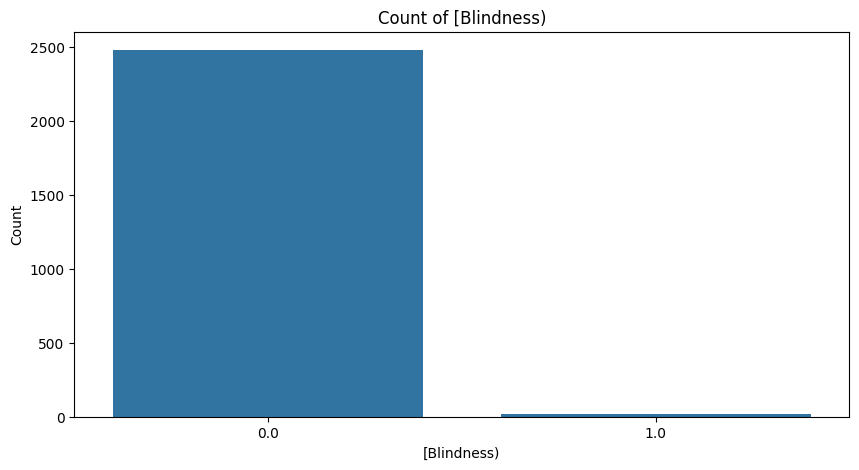



=====[Retinopathy)=====
Column: [Retinopathy)

[Retinopathy)
0.0    98.917836
1.0     1.082164
Name: proportion, dtype: float64


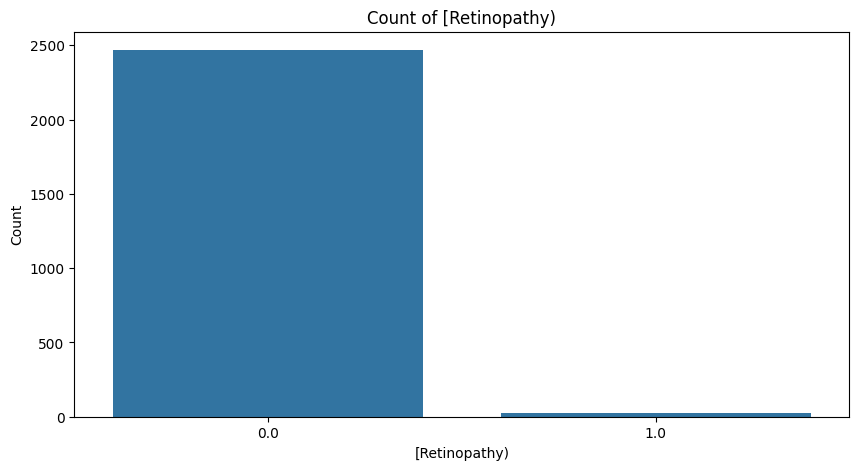



=====[RetinalTear)=====
Column: [RetinalTear)

[RetinalTear)
0.0    99.839679
1.0     0.160321
Name: proportion, dtype: float64


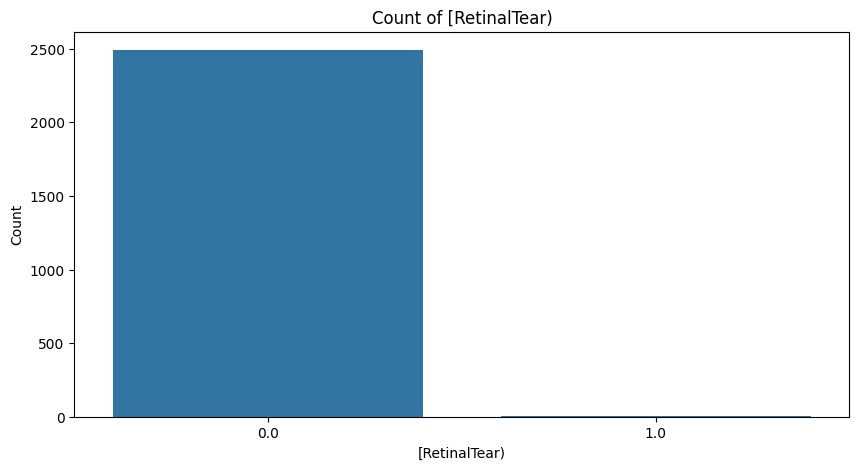

In [ ]:
for c in cat_columns:
  print(f"====={c}=====")
  assess_categorical(df, c)

In [ ]:
df.drop("[PeritonealDialysis)", axis=1)

In [ ]:
cat_columns.remove("[PeritonealDialysis)")

## Exploratory analysis: continuous variables

In [ ]:
def assess_skew_outliers(df, col):
  print(f"Column: {col}\n")
  print(df[col].describe())
  print("\n")

  fig, ax = plt.subplots(1,2)
  plt.figure(figsize=(20, 10))
  sns.boxplot(x = df[col], ax = ax[0])
  sns.histplot(x = df[col], kde = True, ax = ax[1])

  fig.show()

In [ ]:
def count_outliers(df, col, return_outliers = False):

  q3, q1 = np.nanpercentile(df[col], [75,25])
  iqr = q3 - q1

  upper_whisker = q3 + 1.5*iqr
  lower_whisker = q1 - 1.5*iqr

  remaining = len(df[(df[col]< upper_whisker) & (df[col] > lower_whisker)])

  upper_outliers = list(df[df[col] > upper_whisker].index)

  lower_outliers = list(df[df[col] < lower_whisker].index)

  total_outliers = len(upper_outliers) + len(lower_outliers)

  print(f"remaining: {remaining}")
  print(f"upper outliers: {len(upper_outliers)}")
  print(f"lower outliers: {len(lower_outliers)}")
  print(f"total outliers: {total_outliers}")

  if return_outliers:
    return upper_outliers, lower_outliers

In [ ]:
def assess_continuous(df, col):
  assess_skew_outliers(df, col)
  count_outliers(df, col)
  print("\n")

Column: BMI

count    23970.000000
mean        31.639858
std          7.816554
min          5.100000
25%         26.800000
50%         30.413898
75%         35.000000
max        239.200000
Name: BMI, dtype: float64


remaining: 23139
upper outliers: 813
lower outliers: 16
total outliers: 829




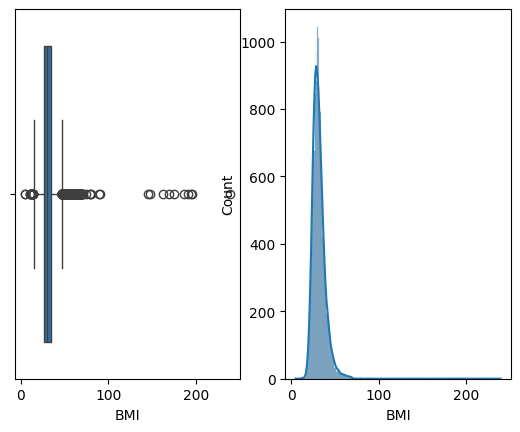

<Figure size 2000x1000 with 0 Axes>

In [ ]:
assess_continuous(df, "BMI")

Column: Age_at_Exam

count    23970.000000
mean        64.158156
std         13.405684
min         18.000000
25%         55.000000
50%         65.000000
75%         74.000000
max         90.000000
Name: Age_at_Exam, dtype: float64


remaining: 23795
upper outliers: 0
lower outliers: 175
total outliers: 175




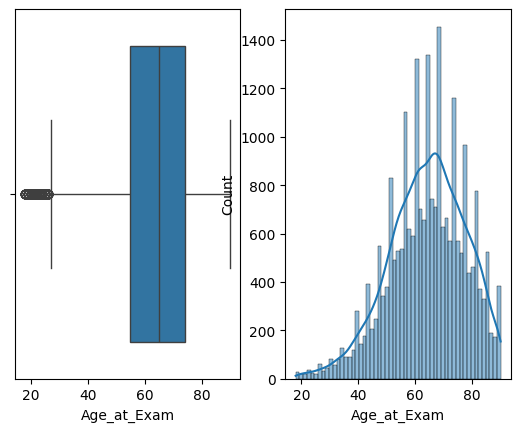

<Figure size 2000x1000 with 0 Axes>

In [ ]:
assess_skew_outliers(df, "Age_at_Exam")
count_outliers(df, "Age_at_Exam")
print("\n")

Column: A1c

count    19859.000000
mean         6.886605
std          1.191315
min          0.550000
25%          6.200000
50%          6.600000
75%          7.300000
max         16.400000
Name: A1c, dtype: float64


remaining: 18673
upper outliers: 1170
lower outliers: 16
total outliers: 1186




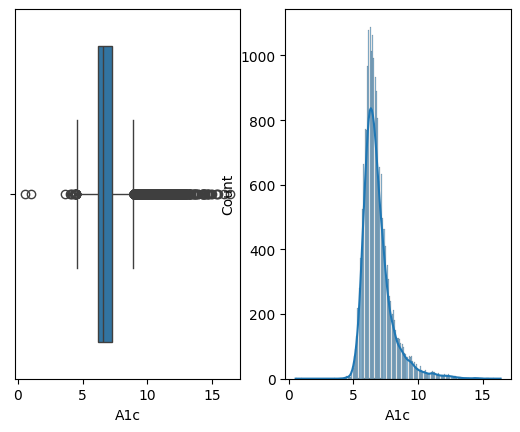

<Figure size 2000x1000 with 0 Axes>

In [ ]:
assess_skew_outliers(df, "A1c")
count_outliers(df, "A1c")
print("\n")

## Analyzing missingness

In [ ]:
def count_nas(df):
  tot = len(df)
  cols = list(df.columns)
  nas = [df[col].isna().sum() for col in cols]
  percent_nas = [na/tot * 100 for na in nas]

  na_df = pd.DataFrame.from_dict({"col": cols, "nas": nas, "percent_nas": percent_nas})
  na_df.sort_values(by = "percent_nas", ascending = False, inplace = True)
  na_df = na_df.reset_index(drop = True)

  return na_df

In [ ]:
na_df = count_nas(df)

cols_with_missing = list(na_df[na_df.percent_nas > 0].col)
cols_with_missing

['[Depression_Date]',
 '[Anxiety_Date]',
 '[Neuropathy)',
 '[Nephropathy)',
 '[RetinalTear)',
 '[Retinopathy)',
 '[Blindness)',
 '[Anxiety)',
 '[Cardiomyopathy)',
 '[Proteinuria)',
 '[Dialysis)',
 '[Amputation)',
 '[PVD)',
 'total_b_R1_[2ndline-antidiabetic]_Records',
 'total_b_R1_[1stlineantidiabetic]_Records',
 'A1c']

In [ ]:
cont_col_with_missing = ["total_b_R1_[1stlineantidiabetic]_Records", "total_b_R1_[2ndline-antidiabetic]_Records",
                         "A1c"]
cat_col_with_missing = [c for c in cols_with_missing if c not in cont_col_with_missing + dates]

In [ ]:
def check_mcar(df, missing_col: str, compare: str):
    df_missing = df.copy()
    df_missing["Missingness"] = df_missing[missing_col].isnull().map({True: "Missing", False: "Present"})

    plt.figure(figsize=(6, 4))
    sns.countplot(data = df_missing, x="Missingness", hue = compare)
    plt.title(f"Comparison of {compare} by Missingness in {missing_col}")
    plt.show()

==========Missingness in [Neuropathy):==========


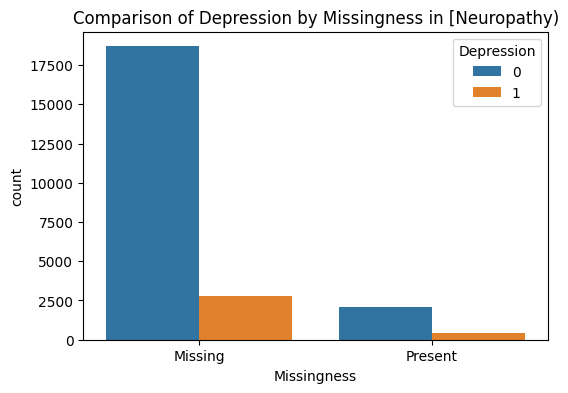

Percent depressed when [Neuropathy) is missing: 12.98%
Percent depressed when [Neuropathy) is not missing: 17.52%



==========Depression count by [Neuropathy):==========
Depression       0    1
[Neuropathy)           
0.0           1924  402
1.0            134   35


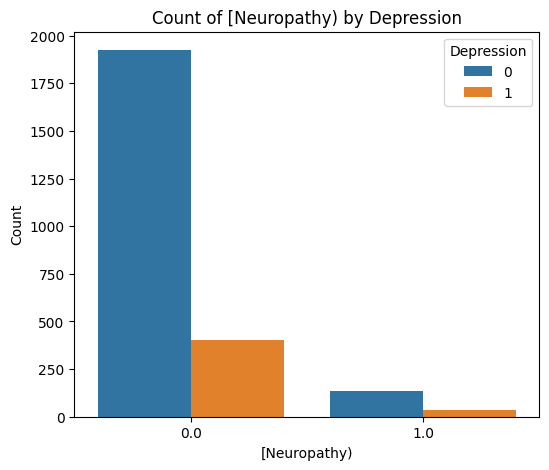

Percent depressed when [Neuropathy) = 0: 17.28%
Percent depressed when [Neuropathy) = 1: 20.71%



==========Missingness in [Nephropathy):==========


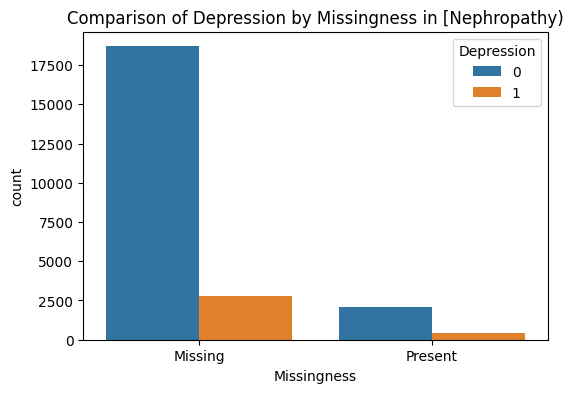

Percent depressed when [Nephropathy) is missing: 12.98%
Percent depressed when [Nephropathy) is not missing: 17.52%



==========Depression count by [Nephropathy):==========
Depression        0    1
[Nephropathy)           
0.0            2039  431
1.0              19    6


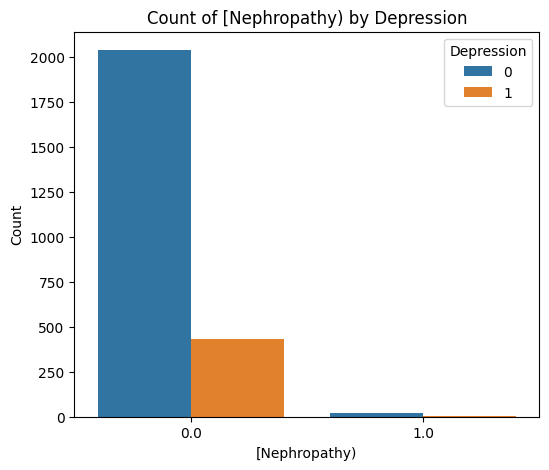

Percent depressed when [Nephropathy) = 0: 17.45%
Percent depressed when [Nephropathy) = 1: 24.0%



==========Missingness in [RetinalTear):==========


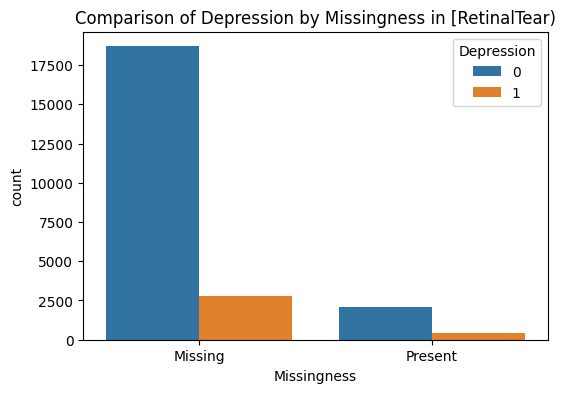

Percent depressed when [RetinalTear) is missing: 12.98%
Percent depressed when [RetinalTear) is not missing: 17.52%



==========Depression count by [RetinalTear):==========
Depression        0    1
[RetinalTear)           
0.0            2055  436
1.0               3    1


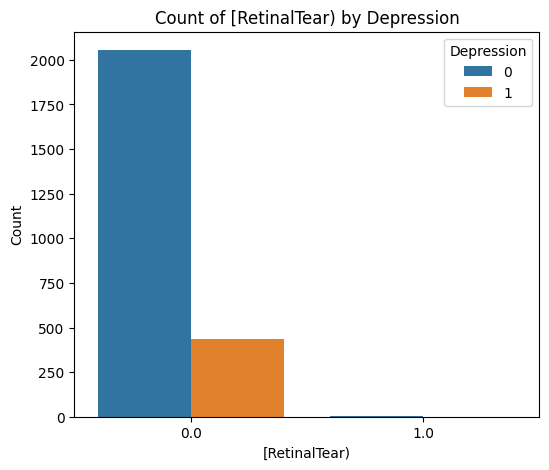

Percent depressed when [RetinalTear) = 0: 17.5%
Percent depressed when [RetinalTear) = 1: 25.0%



==========Missingness in [Retinopathy):==========


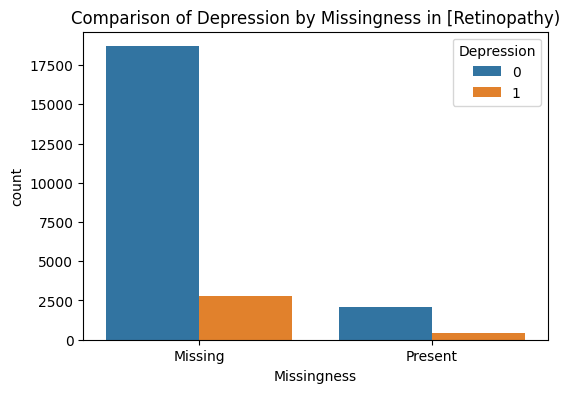

Percent depressed when [Retinopathy) is missing: 12.98%
Percent depressed when [Retinopathy) is not missing: 17.52%



==========Depression count by [Retinopathy):==========
Depression        0    1
[Retinopathy)           
0.0            2037  431
1.0              21    6


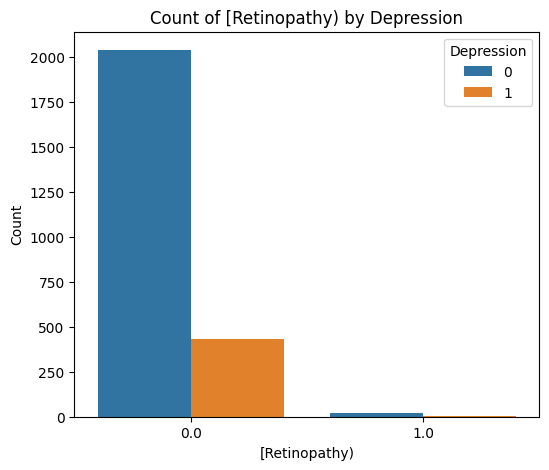

Percent depressed when [Retinopathy) = 0: 17.46%
Percent depressed when [Retinopathy) = 1: 22.22%



==========Missingness in [Blindness):==========


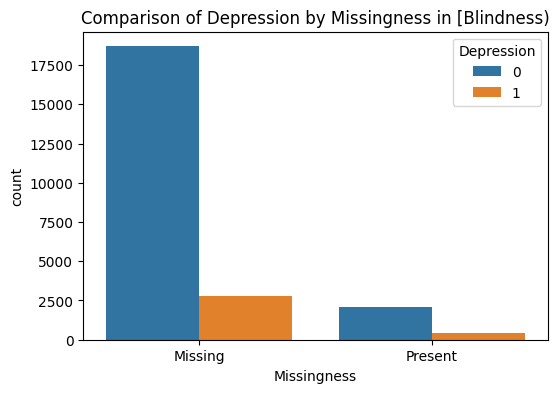

Percent depressed when [Blindness) is missing: 12.98%
Percent depressed when [Blindness) is not missing: 17.52%



==========Depression count by [Blindness):==========
Depression      0    1
[Blindness)           
0.0          2043  434
1.0            15    3


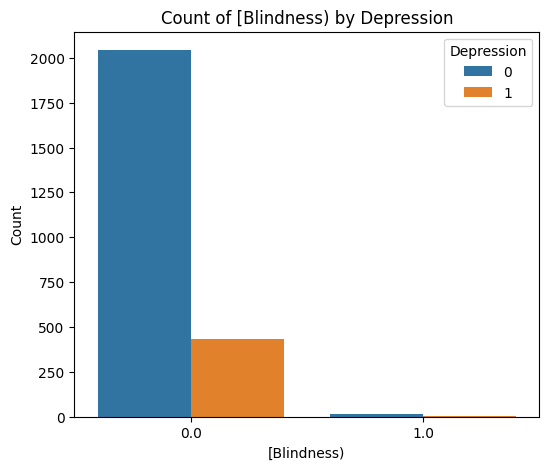

Percent depressed when [Blindness) = 0: 17.52%
Percent depressed when [Blindness) = 1: 16.67%



==========Missingness in [Anxiety):==========


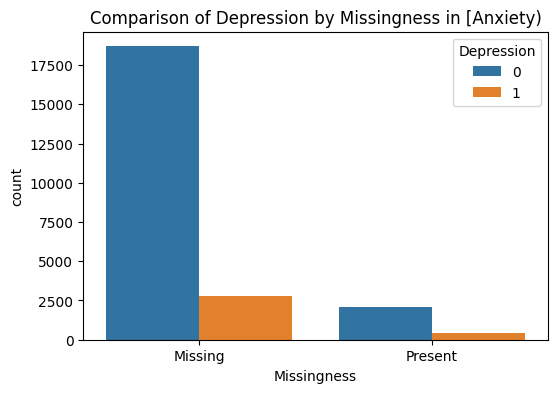

Percent depressed when [Anxiety) is missing: 12.98%
Percent depressed when [Anxiety) is not missing: 17.52%



==========Depression count by [Anxiety):==========
Depression     0    1
[Anxiety)            
0.0         1646  250
1.0          412  187


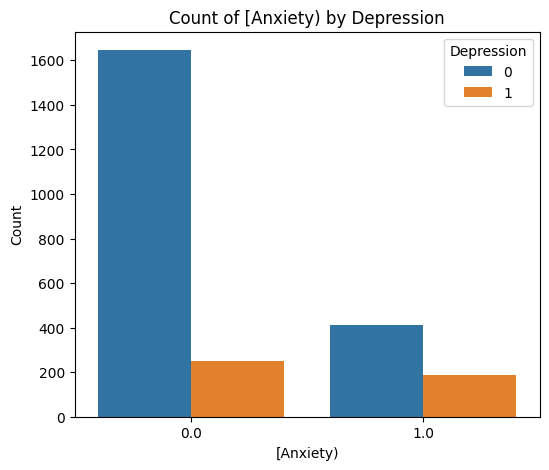

Percent depressed when [Anxiety) = 0: 13.19%
Percent depressed when [Anxiety) = 1: 31.22%



==========Missingness in [Cardiomyopathy):==========


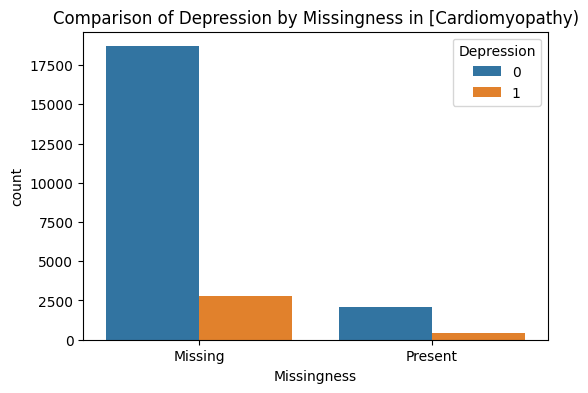

Percent depressed when [Cardiomyopathy) is missing: 12.98%
Percent depressed when [Cardiomyopathy) is not missing: 17.52%



==========Depression count by [Cardiomyopathy):==========
Depression           0    1
[Cardiomyopathy)           
0.0               2040  432
1.0                 18    5


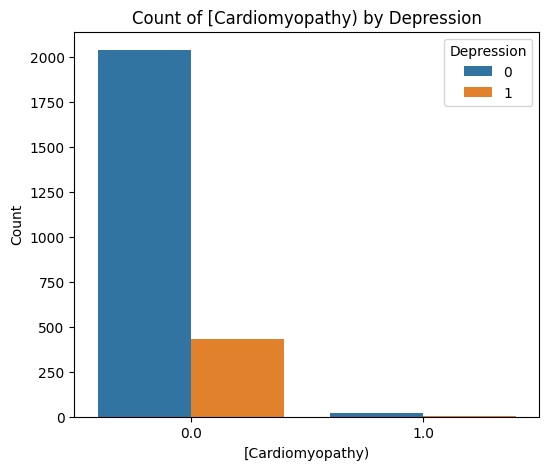

Percent depressed when [Cardiomyopathy) = 0: 17.48%
Percent depressed when [Cardiomyopathy) = 1: 21.74%



==========Missingness in [Proteinuria):==========


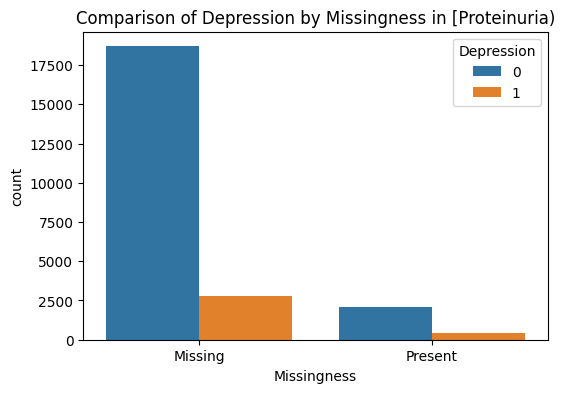

Percent depressed when [Proteinuria) is missing: 12.98%
Percent depressed when [Proteinuria) is not missing: 17.52%



==========Depression count by [Proteinuria):==========
Depression        0    1
[Proteinuria)           
0.0            2017  432
1.0              41    5


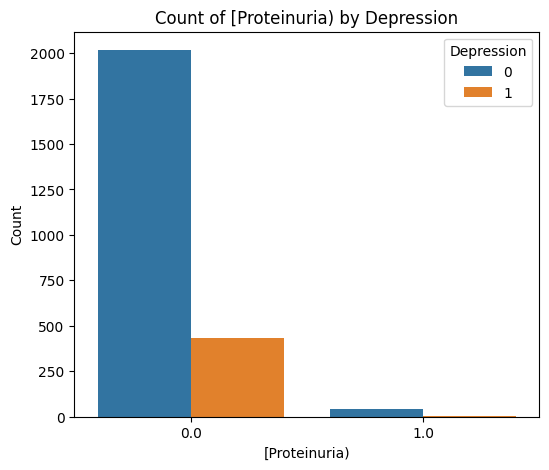

Percent depressed when [Proteinuria) = 0: 17.64%
Percent depressed when [Proteinuria) = 1: 10.87%



==========Missingness in [Dialysis):==========


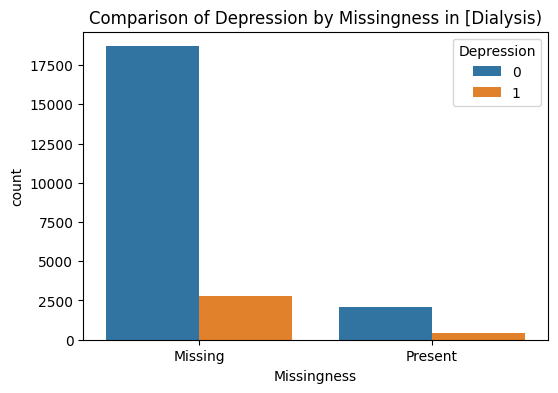

Percent depressed when [Dialysis) is missing: 12.98%
Percent depressed when [Dialysis) is not missing: 17.52%



==========Depression count by [Dialysis):==========
Depression     0    1
[Dialysis)           
0.0         2052  436
1.0            6    1


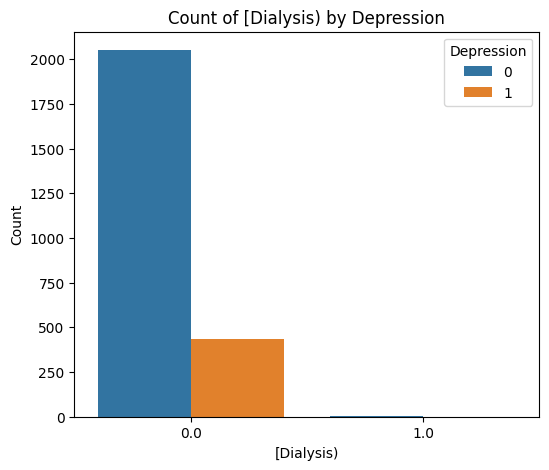

Percent depressed when [Dialysis) = 0: 17.52%
Percent depressed when [Dialysis) = 1: 14.29%



==========Missingness in [Amputation):==========


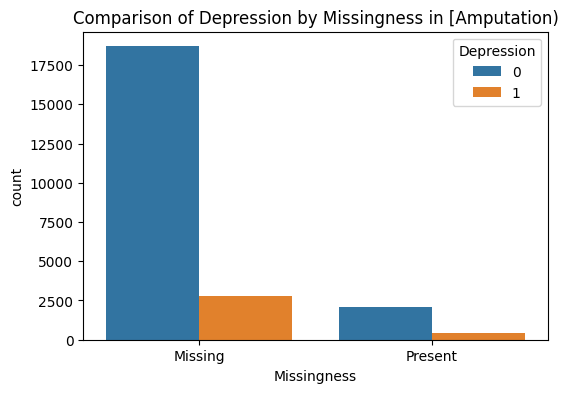

Percent depressed when [Amputation) is missing: 12.98%
Percent depressed when [Amputation) is not missing: 17.52%



==========Depression count by [Amputation):==========
Depression       0    1
[Amputation)           
0.0           2023  435
1.0             35    2


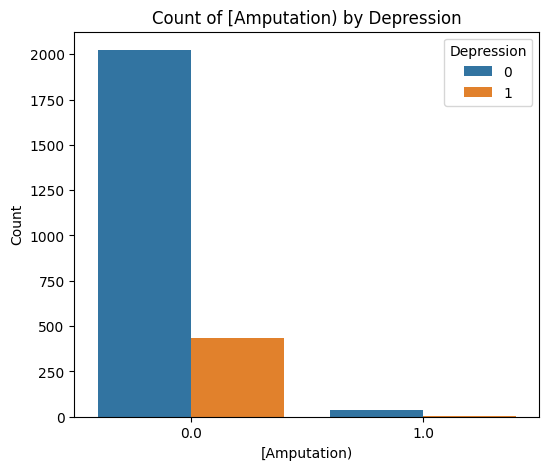

Percent depressed when [Amputation) = 0: 17.7%
Percent depressed when [Amputation) = 1: 5.41%



==========Missingness in [PVD):==========


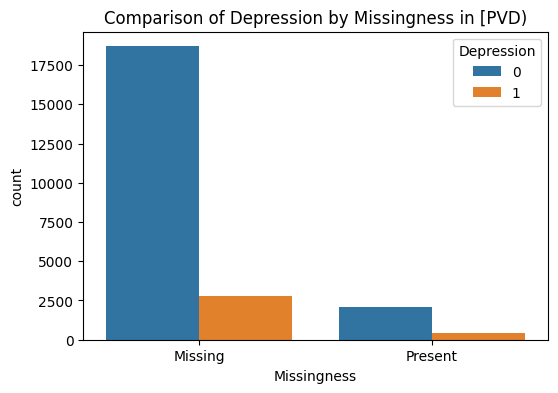

Percent depressed when [PVD) is missing: 12.98%
Percent depressed when [PVD) is not missing: 17.52%



==========Depression count by [PVD):==========
Depression     0    1
[PVD)                
0.0         1967  426
1.0           91   11


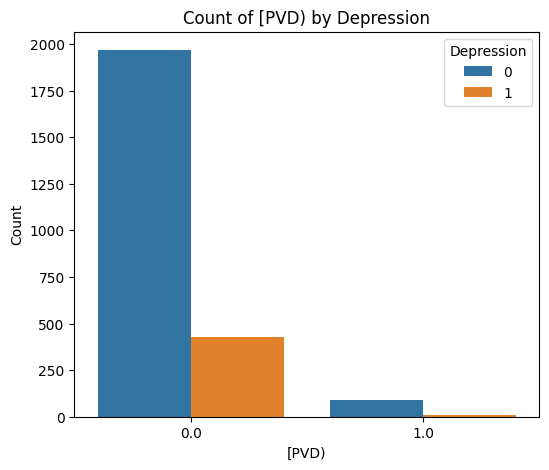

Percent depressed when [PVD) = 0: 17.8%
Percent depressed when [PVD) = 1: 10.78%





In [ ]:
for c in cat_col_with_missing:

  print(f"==========Missingness in {c}:==========")

  check_mcar(df, c, "Depression")

  percent_depressed_when_na = df[df[c].isnull()==True]['Depression'].sum()/len(df[df[c].isnull()==True])*100
  percent_depressed_when_not_na = df[df[c].isnull()==False]['Depression'].sum()/len(df[df[c].isnull()==False])*100

  print(f"Percent depressed when {c} is missing: {round(percent_depressed_when_na, 2)}%")
  print(f"Percent depressed when {c} is not missing: {round(percent_depressed_when_not_na, 2)}%")
  print("\n\n")

  print(f"==========Depression count by {c}:==========")
  contingency_table = pd.crosstab(df[c], df['Depression'])
  print(contingency_table)

  plt.figure(figsize=(6, 5))
  sns.countplot(
    data=df,
    x= c, hue="Depression")

  plt.xlabel(c)
  plt.ylabel('Count')
  plt.title(f'Count of {c} by Depression')
  plt.legend(title='Depression')
  plt.show()

  percent_depressed_when_0 = df[df[c]==0]['Depression'].sum()/len(df[df[c]==0])*100
  percent_depressed_when_1 = df[df[c]==1]['Depression'].sum()/len(df[df[c]==1])*100

  print(f"Percent depressed when {c} = 0: {round(percent_depressed_when_0, 2)}%")
  print(f"Percent depressed when {c} = 1: {round(percent_depressed_when_1, 2)}%")
  print("\n\n")

==========Depression count by total_b_R1_[1stlineantidiabetic]_Records:==========


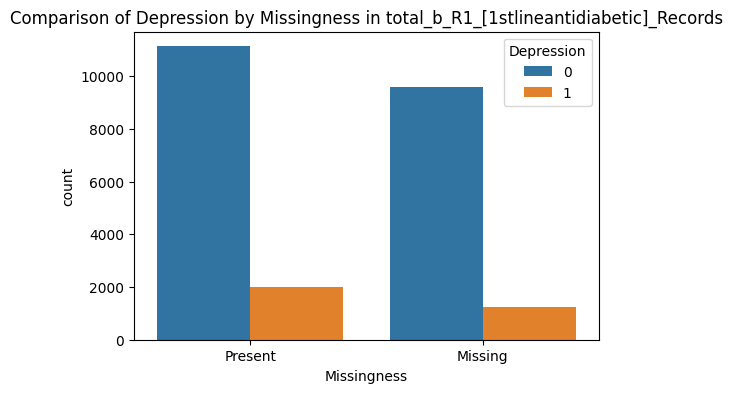

Percent depressed when total_b_R1_[1stlineantidiabetic]_Records is missing: 11.32%
Percent depressed when total_b_R1_[1stlineantidiabetic]_Records is not missing: 15.21%



==========Depression count by total_b_R1_[2ndline-antidiabetic]_Records:==========


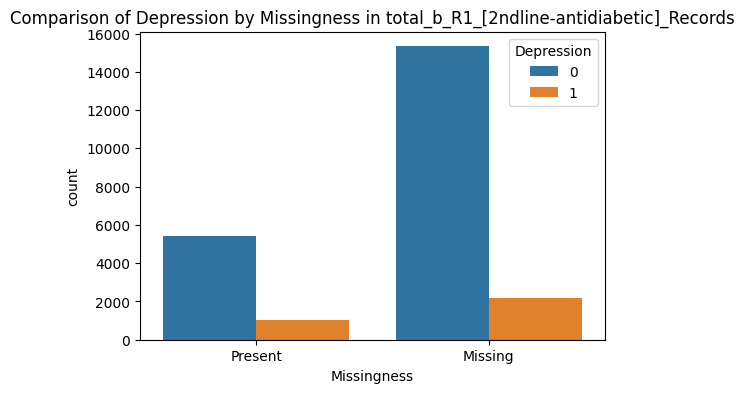

Percent depressed when total_b_R1_[2ndline-antidiabetic]_Records is missing: 12.5%
Percent depressed when total_b_R1_[2ndline-antidiabetic]_Records is not missing: 16.03%



==========Depression count by A1c:==========


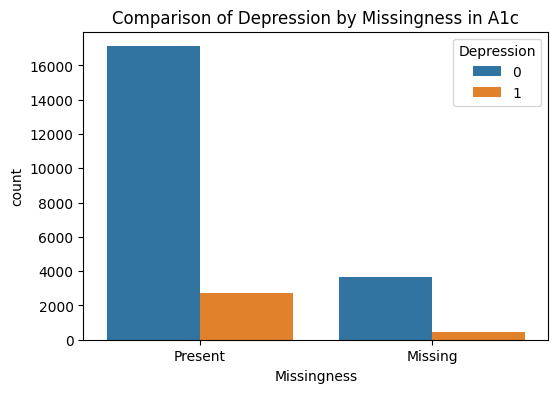

Percent depressed when A1c is missing: 11.65%
Percent depressed when A1c is not missing: 13.83%





In [ ]:
for c in cont_col_with_missing:
  print(f"==========Depression count by {c}:==========")
  check_mcar(df, c, "Depression")

  percent_when_na = df[df[c].isnull()==True]['Depression'].sum()/len(df[df[c].isnull()==True])*100
  percent_when_not_na = df[df[c].isnull()==False]['Depression'].sum()/len(df[df[c].isnull()==False])*100

  print(f"Percent depressed when {c} is missing: {round(percent_when_na, 2)}%")
  print(f"Percent depressed when {c} is not missing: {round(percent_when_not_na, 2)}%")

  print("\n\n")

### Missingness in diabetes co-morbidity variables

In [ ]:
cols = ['[PeritonealDialysis)', '[PVD)', '[Neuropathy)', '[Nephropathy)',
        '[Amputation)', '[Dialysis)', '[Proteinuria)', '[Cardiomyopathy)', "[Anxiety)"]

# missing indixes in "[Peritoneal Dialysis)"
missing_indices = set(df[df[cols[0]].isnull()].index)

# Check if all other columns have the exact same missing indices
all(set(df[df[col].isnull()].index) == missing_indices for col in cols[1:])

True

### Missingness in drug records

In [ ]:
df["total_b_R1_[1stlineantidiabetic]_Records"].unique()

array([10., nan,  6.,  4., 12.,  1.,  7.,  2., 14.,  9., 13.,  3.,  5.,
        8., 20., 11., 42., 32., 18., 27., 22., 86., 17., 37., 25., 19.,
       16., 24., 15., 39., 23., 34., 33., 26., 51., 28., 30., 71., 35.,
       21., 29., 31., 36., 52., 38., 74., 50., 49., 43., 41., 40., 44.,
       79., 46., 47., 57., 53., 54., 45., 76., 48., 56.])

In [ ]:
df["total_b_R1_[2ndline-antidiabetic]_Records"].unique()

array([ 2., nan,  3., 11., 10.,  6.,  1.,  7., 18.,  4., 20.,  5.,  8.,
        9., 64., 14., 21., 12., 13., 17., 19., 53., 16., 26., 15., 24.,
       25., 23., 28., 50., 36., 30., 31., 33., 55., 29., 35., 37., 22.,
       44., 39., 49., 45., 27., 32., 41., 40., 34., 69., 51., 38., 52.,
       68., 47., 63., 43., 61., 86., 54., 46., 42., 48., 60., 58., 56.,
       76., 62.])

Overall, should not use MICE or other imputation methods for the above variables because there is too much missingness. However, when further observing the values of the variables and missingness, noticed that:
1. Missingness does not appear to be associated with depression status of the patient (i.e., missing at random)
2. The same records are missing across all comorbidities
3. There is no "0" value in records of medicine

Conclude: impute missing drug rows with 0 (i.e., assume no records), impute missing comorbidities as 0 (i.e., assume not present)

## Feature engineering

In [ ]:
def check_abnormal_bmi(value):
  if value > 30 or value < 18:
    return 1
  else:
    return 0

In [ ]:
def check_abnormal_A1c(value):
  if value >= 6.5:
    return 1
  else:
    return 0

In [ ]:
df["Abnormal_BMI"] = df["BMI"].map(check_abnormal_bmi)
df["Abnormal_A1c"] = df["A1c"].map(check_abnormal_A1c)

<ipython-input-140-5f32bb302530>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Abnormal_BMI"] = df["BMI"].map(check_abnormal_bmi)
<ipython-input-140-5f32bb302530>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Abnormal_A1c"] = df["A1c"].map(check_abnormal_A1c)


In [ ]:
def encode_sex(sex):
  if sex == "Male":
    return 1
  else:
    return 0

In [ ]:
df["Sex_01"] = df["Sex"].map(encode_sex)

<ipython-input-143-53f87d9f7232>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Sex_01"] = df["Sex"].map(encode_sex)


In [ ]:
df_imputed = df.copy()

# impute missing comorbidities as 0 (i.e., assume not present)
df_imputed[cat_col_with_missing] = df_imputed[cat_col_with_missing].fillna(0)

drugs = ['total_b_R1_[1stlineantidiabetic]_Records', 'total_b_R1_[2ndline-antidiabetic]_Records']

# impute missing drug rows with 0 (i.e., assume no records)
df_imputed[drugs] = df_imputed[drugs].fillna(0)

In [ ]:
df_imputed.head(10)

,Depression,[Depression_Date],Age_at_Exam,BMI,Sex,A1c,b_R1_sleep,b_R1_kidney,b_R1_heart,b_R1_brain,...,[Anxiety),[Anxiety_Date],[Blindness),[Retinopathy),[RetinalTear),total_b_R1_[1stlineantidiabetic]_Records,total_b_R1_[2ndline-antidiabetic]_Records,Abnormal_BMI,Abnormal_A1c,Sex_01
0,0,NaN,88,35.000000,Female,6.2,0,0,0,0,...,0.0,NaN,0.0,0.0,0.0,10.0,2.0,1,0,0
1,0,NaN,76,35.030000,Female,NaN,0,0,0,0,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1,0,0
2,0,NaN,63,22.800000,Female,7.6,0,0,0,0,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0
3,0,NaN,58,32.000000,Male,5.7,0,0,0,0,...,0.0,NaN,0.0,0.0,0.0,0.0,3.0,1,0,1
4,0,NaN,69,30.760000,Male,6.9,0,0,0,0,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1,1,1
5,0,NaN,77,25.390219,Female,6.8,0,0,0,0,...,0.0,NaN,0.0,0.0,0.0,6.0,11.0,0,1,0
6,0,NaN,37,27.000000,Female,7.0,0,0,0,0,...,0.0,NaN,0.0,0.0,0.0,0.0,10.0,0,1,0
7,0,NaN,47,42.000000,Female,6.5,0,0,0,0,...,0.0,NaN,0.0,0.0,0.0,4.0,0.0,1,1,0
8,0,NaN,73,31.000000,Male,6.5,0,0,0,0,...,0.0,NaN,0.0,0.0,0.0,12.0,6.0,1,1,1
9,0,NaN,61,39.000000,Female,6.2,0,0,0,0,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1,0,0


In [ ]:
columns = list(df_imputed.columns)
columns.remove("Abnormal_BMI")
columns.remove("Abnormal_A1c")
columns.remove("Sex_01")

table = TableOne(df_imputed[columns], columns, cat_columns[0:18], cont_columns, groupby = "Depression")
table

/usr/local/lib/python3.11/dist-packages/tableone/tableone.py:322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self._categorical] = handle_categorical_nulls(data[self._categorical])


Grouped by Depression                                            
                                                                          Missing        Overall              0             1
n                                                                                          23970          20745          3225
Depression, n (%)                                    0                              20745 (86.5)  20745 (100.0)              
                                                     1                               3225 (13.5)                 3225 (100.0)
Age_at_Exam, mean (SD)                                                          0    64.2 (13.4)    64.3 (13.4)   63.0 (13.5)
BMI, mean (SD)                                                                  0     31.6 (7.8)     31.5 (7.7)    32.5 (8.5)
Sex, n (%)                                           Female                         11401 (47.6)    9430 (45.5)   1971 (61.1)
                                                     Male                           12569 (52.4)   11315 (54.5)   1254 (38.9)
A1c, mean (SD)                                                               4111      6.9 (1.2)      6.9 (1.2)     6.8 (1.2)
b_R1_sleep, n (%)                                    0                              23537 (98.2)   20425 (98.5)   3112 (96.5)
                                                     1                                 433 (1.8)      320 (1.5)     113 (3.5)
b_R1_kidney, n (%)                                   0                              23635 (98.6)   20468 (98.7)   3167 (98.2)
                                                     1                                 335 (1.4)      277 (1.3)      58 (1.8)
b_R1_heart, n (%)                                    0                              22722 (94.8)   19691 (94.9)   3031 (94.0)
                                                     1                                1248 (5.2)     1054 (5.1)     194 (6.0)
b_R1_brain, n (%)                                    0                              23610 (98.5)   20464 (98.6)   3146 (97.6)
                                                     1                                 360 (1.5)      281 (1.4)      79 (2.4)
b_R1_eye, n (%)                                      0                              23395 (97.6)   20250 (97.6)   3145 (97.5)
                                                     1                                 575 (2.4)      495 (2.4)      80 (2.5)
[PVD), n (%)                                         0.0                            23868 (99.6)   20654 (99.6)   3214 (99.7)
                                                     1.0                               102 (0.4)       91 (0.4)      11 (0.3)
[Neuropathy), n (%)                                  0.0                            23801 (99.3)   20611 (99.4)   3190 (98.9)
                                                     1.0                               169 (0.7)      134 (0.6)      35 (1.1)
[Nephropathy), n (%)                                 0.0                            23945 (99.9)   20726 (99.9)   3219 (99.8)
                                                     1.0                                25 (0.1)       19 (0.1)       6 (0.2)
[Amputation), n (%)                                  0.0                            23933 (99.8)   20710 (99.8)   3223 (99.9)
                                                     1.0                                37 (0.2)       35 (0.2)       2 (0.1)
[Dialysis), n (%)                                    0.0                           23963 (100.0)  20739 (100.0)  3224 (100.0)
                                                     1.0                                 7 (0.0)        6 (0.0)       1 (0.0)
[Proteinuria), n (%)                                 0.0                            23924 (99.8)   20704 (99.8)   3220 (99.8)
                                                     1.0                                46 (0.2)       41 (0.2)       5 (0.2)
[Cardiomyopathy), n (%)     

# Training models
1. Domain 1: Diabetes comorbidities
2. Domain 2: Diabetes management
3. Domain 3: Sociodemographic characteristics

## Functions

In [ ]:
def impute_and_transform(df, Xs: list, y: str, impute = False, smote = False):
  X = df[Xs]
  y = df[y]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  if impute:
    imputer = IterativeImputer(max_iter=10, random_state=42)
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

  if smote:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

  # Normalizing data
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)  # Fit and transform on the training set
  X_test = scaler.transform(X_test)        # transform the test set

  return X_train, X_test, y_train, y_test

In [ ]:
def find_best_params(model, param_grid, X_train, y_train, cv = 5):
  grid_search = GridSearchCV(model, param_grid, cv=5)
  grid_search.fit(X_train, y_train)

  return grid_search.best_params_

In [ ]:
def get_scores(y_pred, y):
  conf_matrix = confusion_matrix(y, y_pred)
  class_report = classification_report(y, y_pred)
  acc = accuracy_score(y, y_pred)
  return conf_matrix, class_report, acc

In [ ]:
def print_our_scores(conf_matrix, class_report, acc):
  print("Confusion Matrix:")
  print(conf_matrix)
  print("\nClassification Report:")
  print(class_report)
  print("\nAccuracy:", acc)

In [ ]:
def plot_confusion_matrix(conf_matrix):
  sns.heatmap(conf_matrix, annot=True, fmt='d')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

In [ ]:
def get_auc_values(y_prob, y):
  fpr, tpr, thresholds = roc_curve(y, y_prob)
  roc_auc = roc_auc_score(y, y_prob)
  return fpr, tpr, roc_auc

In [ ]:
def plot_roc_curve(fpr, tpr, roc_auc, title = "ROC AUC Curve"):
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title(title)
  plt.legend(loc='lower right')
  plt.show()

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  y_prob_train = model.predict_proba(X_train)[:, 1]
  y_prob_test = model.predict_proba(X_test)[:, 1]

  # Calculate evaluation metrics and scores for the test and training sets
  conf_matrix_train, class_report_train, acc_train = get_scores(y_pred_train, y_train)
  conf_matrix_test, class_report_test, acc_test = get_scores(y_pred_test, y_test)

  # Print scores and evaluation metrics for the training set
  print("======== Training Set ==========")
  print_our_scores(conf_matrix_train, class_report_train, acc_train)
  plot_confusion_matrix(conf_matrix_train) # plot the confusion matrix for the training set using the function we created above

  fpr_train, tpr_train, roc_auc_train = get_auc_values(y_prob_train, y_train)
  print(f"Training AUC: {roc_auc_train:.4f}")
  plot_roc_curve(fpr_train, tpr_train, roc_auc_train)

  # Print scores and evaluation metrics for the test set
  print('======== Test Set ==========')
  print_our_scores(conf_matrix_test, class_report_test, acc_test)
  plot_confusion_matrix(conf_matrix_test) # plot the confusion matrix for the test set using the function we created above

  fpr_test, tpr_test, roc_auc_test = get_auc_values(y_prob_test, y_test)
  print(f"Testing AUC: {roc_auc_test:.4f}")
  plot_roc_curve(fpr_test, tpr_test, roc_auc_test)

In [ ]:
def find_best_features(df, model, X_train, y_train, k = 5):
  # Initialize a Logistic Regression model
  model = LogisticRegression()

  # Define a StratifiedKFold cross-validation
  cv = StratifiedKFold(k)

  # Initialize Recursive Feature Elimination with Cross-Validation (RFECV)
  rfecv = RFECV(
      estimator=model,
      step=1,
      cv=cv,
      scoring='roc_auc',  # Specify the scoring metric (ROC AUC in this case)
      min_features_to_select=1,
  )
  rfecv.fit(X_train, y_train)

  print(f"Optimal number of features: {rfecv.n_features_}")

  return list(df.columns[list(rfecv.support_)]), rfecv.support_ # show the features that were chosen by RFECV

## Domain 1: Diabetes comorbidities only

In [ ]:
df_imputed.columns

Index(['Depression', '[Depression_Date]', 'Age_at_Exam', 'BMI', 'Sex', 'A1c',
       'b_R1_sleep', 'b_R1_kidney', 'b_R1_heart', 'b_R1_brain', 'b_R1_eye',
       '[PVD)', '[Neuropathy)', '[Nephropathy)', '[Amputation)', '[Dialysis)',
       '[Proteinuria)', '[Cardiomyopathy)', '[Anxiety)', '[Anxiety_Date]',
       '[Blindness)', '[Retinopathy)', '[RetinalTear)',
       'total_b_R1_[1stlineantidiabetic]_Records',
       'total_b_R1_[2ndline-antidiabetic]_Records', 'Abnormal_BMI',
       'Abnormal_A1c', 'Sex_01'],
      dtype='object')

In [ ]:
comorbidities = ['Abnormal_BMI', 'b_R1_sleep', 'b_R1_kidney', 'b_R1_heart', 'b_R1_brain', 'b_R1_eye',
                 '[PVD)', '[Neuropathy)', '[Nephropathy)', '[Amputation)', '[Dialysis)',
                 '[Proteinuria)', '[Cardiomyopathy)', '[Anxiety)', '[Blindness)',
                 '[Retinopathy)', '[RetinalTear)']

X_comorbidities = df_imputed[comorbidities]
y = df_imputed["Depression"]

X_train_comorbidities, X_test_comorbidities, y_train_comorbidities, y_test_comorbidities = impute_and_transform(df_imputed, comorbidities, "Depression", impute = True, smote = True)

cv_model = LogisticRegression(solver = "liblinear")
param_grid = {"C": [0.05, 0.075, 0.0775, 0.08, 0.085, 0.1, 0.15, 0.2, 1, 10, 100],
              "penalty": ["l1", "l2"]}

best_params = find_best_params(cv_model, param_grid, X_train_comorbidities, y_train_comorbidities)
print(best_params)

C = best_params["C"]
penalty = best_params["penalty"]

{'C': 0.05, 'penalty': 'l1'}


======== Training Set ==========
Confusion Matrix:
[[7090 7437]
 [5785 8742]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.49      0.52     14527
           1       0.54      0.60      0.57     14527

    accuracy                           0.54     29054
   macro avg       0.55      0.54      0.54     29054
weighted avg       0.55      0.54      0.54     29054


Accuracy: 0.5449163626350932


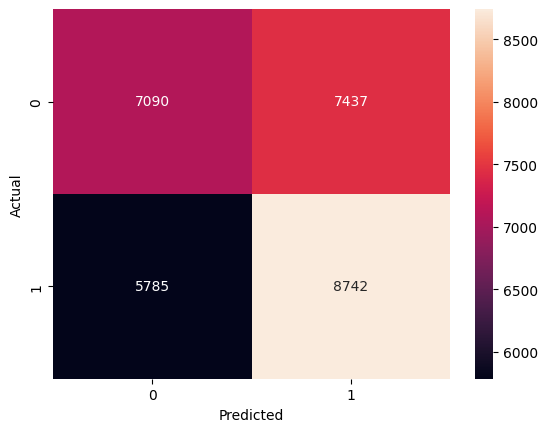

Training AUC: 0.5576


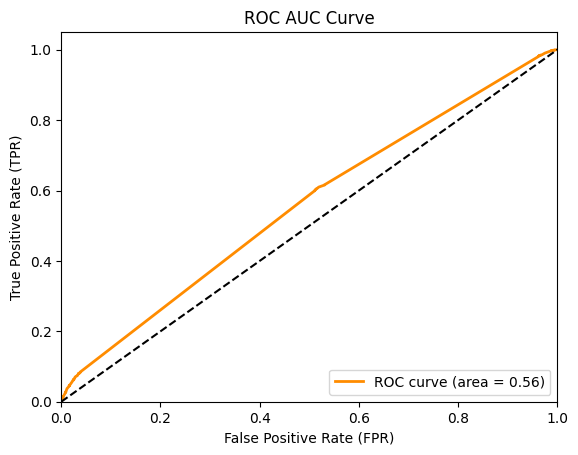

======== Test Set ==========
Confusion Matrix:
[[2991 3227]
 [ 420  553]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.48      0.62      6218
           1       0.15      0.57      0.23       973

    accuracy                           0.49      7191
   macro avg       0.51      0.52      0.43      7191
weighted avg       0.78      0.49      0.57      7191


Accuracy: 0.49283827005979697


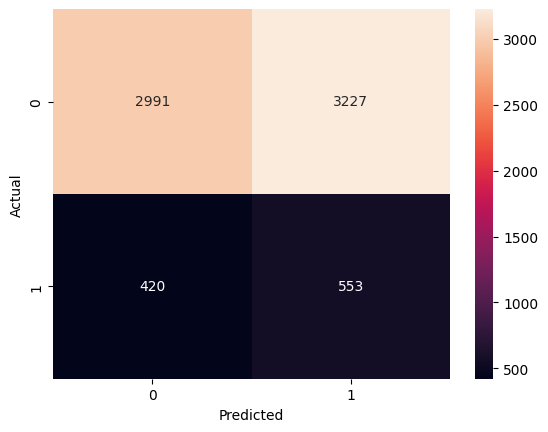

Testing AUC: 0.5412


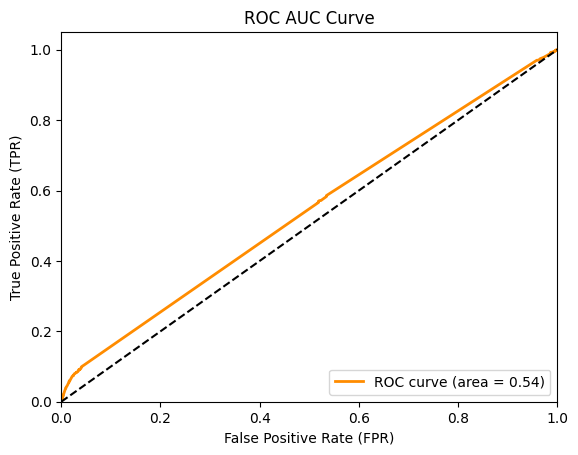

In [ ]:
model_comorbidities = LogisticRegression(penalty=penalty, C=C, class_weight = "balanced", solver = "liblinear")
model_comorbidities.fit(X_train_comorbidities, y_train_comorbidities)

evaluate_model(model_comorbidities, X_train_comorbidities, y_train_comorbidities, X_test_comorbidities, y_test_comorbidities)

In [ ]:
best_features, rfecv_bool = find_best_features(df_imputed[comorbidities], cv_model, X_train_comorbidities, y_train_comorbidities)
print(best_features)

X_train_comorbidities_rfecv = X_train_comorbidities[:, rfecv_bool]
X_test_comorbidities_rfecv = X_test_comorbidities[:, rfecv_bool]

Optimal number of features: 8
['Abnormal_BMI', 'b_R1_sleep', 'b_R1_heart', 'b_R1_brain', '[PVD)', '[Amputation)', '[Proteinuria)', '[Anxiety)']


======== Training Set ==========
Confusion Matrix:
[[7085 7442]
 [5784 8743]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.49      0.52     14527
           1       0.54      0.60      0.57     14527

    accuracy                           0.54     29054
   macro avg       0.55      0.54      0.54     29054
weighted avg       0.55      0.54      0.54     29054


Accuracy: 0.5447786879603497


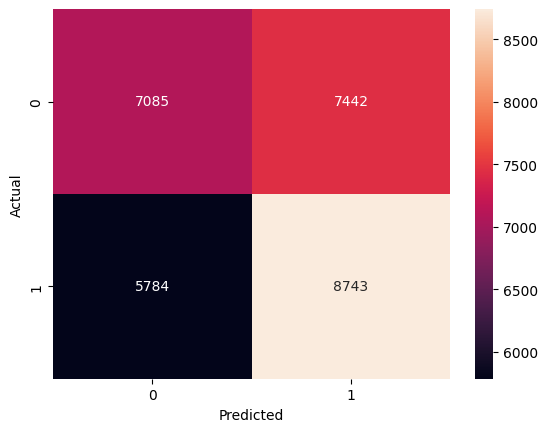

Training AUC: 0.5576


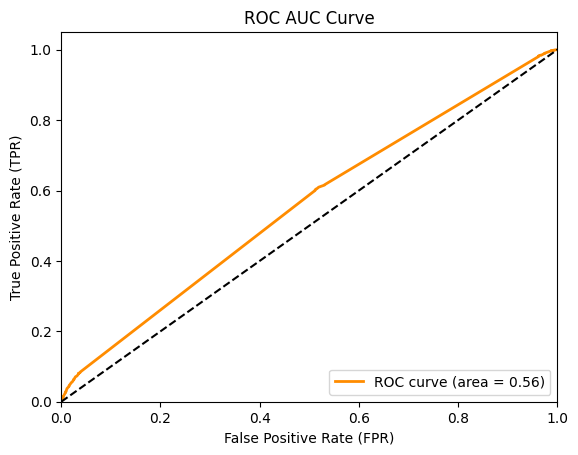

======== Test Set ==========
Confusion Matrix:
[[2990 3228]
 [ 419  554]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.48      0.62      6218
           1       0.15      0.57      0.23       973

    accuracy                           0.49      7191
   macro avg       0.51      0.53      0.43      7191
weighted avg       0.78      0.49      0.57      7191


Accuracy: 0.49283827005979697


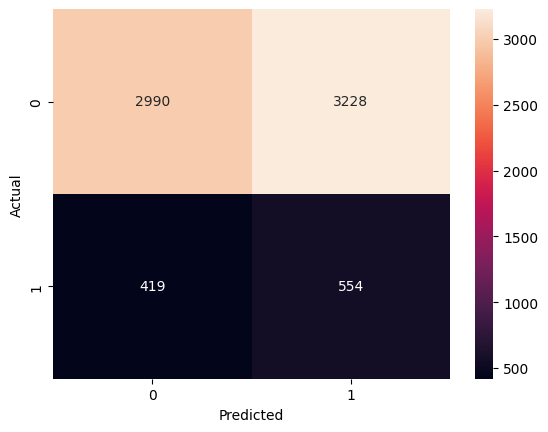

Testing AUC: 0.5405


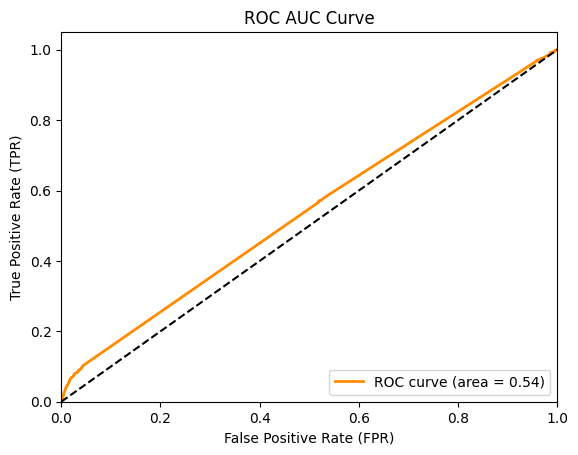

In [ ]:
model_comorbidities_rfecv = LogisticRegression(penalty=penalty, C=C, class_weight = "balanced", solver = "liblinear")
model_comorbidities_rfecv.fit(X_train_comorbidities, y_train_comorbidities)

evaluate_model(model_comorbidities_rfecv, X_train_comorbidities, y_train_comorbidities, X_test_comorbidities, y_test_comorbidities)

## Domain 1a: Diabetes comorbidities with demographic variables

In [ ]:
comorbidities_demographics = ['Age_at_Exam', 'Sex_01', 'Abnormal_BMI', 'b_R1_sleep', 'b_R1_kidney', 'b_R1_heart',
                              'b_R1_brain', 'b_R1_eye', '[PVD)', '[Neuropathy)', '[Nephropathy)', '[Amputation)',
                              '[Dialysis)', '[Proteinuria)', '[Cardiomyopathy)', '[Anxiety)', '[Blindness)',
                              '[Retinopathy)', '[RetinalTear)']

X_comorbidities_demographics = df_imputed[comorbidities_demographics]
y = df_imputed["Depression"]

X_train_comorbidities_demographics, X_test_comorbidities_demographics, y_train_comorbidities_demographics, y_test_comorbidities_demographics = impute_and_transform(df_imputed, comorbidities_demographics, "Depression", impute = True, smote = True)

cv_model = LogisticRegression(solver = "liblinear")
param_grid = {"C": [0.05, 0.075, 0.0775, 0.08, 0.085, 0.1, 0.15, 0.2, 1, 10, 100],
              "penalty": ["l1", "l2"]}

best_params = find_best_params(cv_model, param_grid, X_train_comorbidities_demographics, y_train_comorbidities_demographics)
print(best_params)

C = best_params["C"]
penalty = best_params["penalty"]

{'C': 0.085, 'penalty': 'l1'}


======== Training Set ==========
Confusion Matrix:
[[8076 6451]
 [5567 8960]]

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.56      0.57     14527
           1       0.58      0.62      0.60     14527

    accuracy                           0.59     29054
   macro avg       0.59      0.59      0.59     29054
weighted avg       0.59      0.59      0.59     29054


Accuracy: 0.5863564397329112


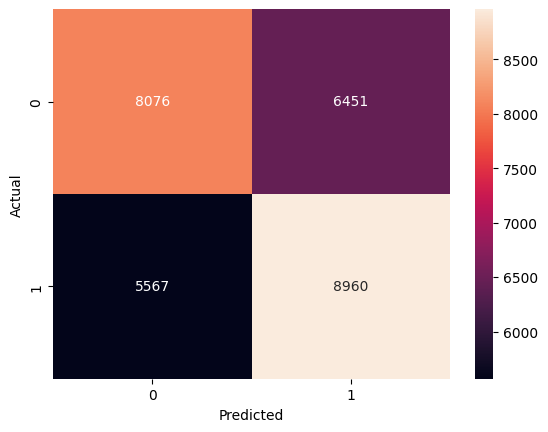

Training AUC: 0.6098


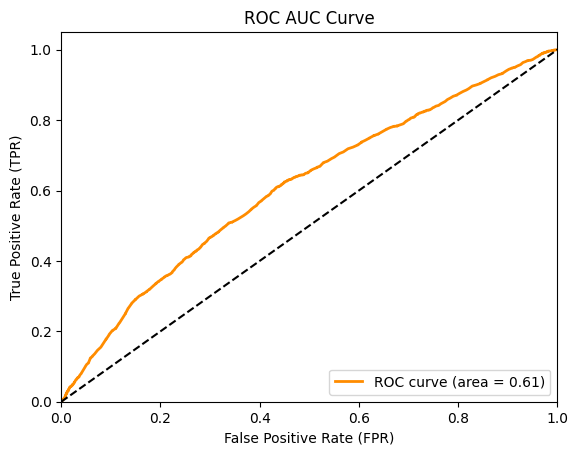

======== Test Set ==========
Confusion Matrix:
[[3515 2703]
 [ 376  597]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.57      0.70      6218
           1       0.18      0.61      0.28       973

    accuracy                           0.57      7191
   macro avg       0.54      0.59      0.49      7191
weighted avg       0.81      0.57      0.64      7191


Accuracy: 0.5718258934779585


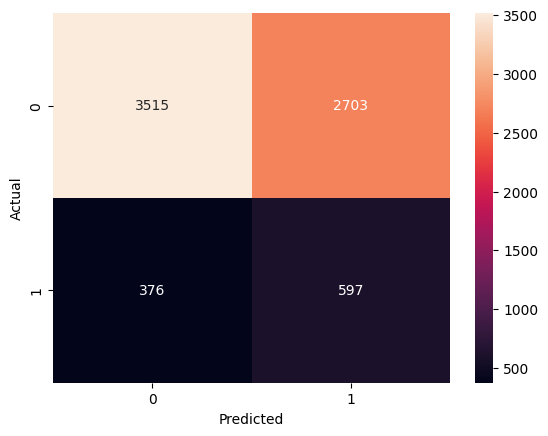

Testing AUC: 0.6064


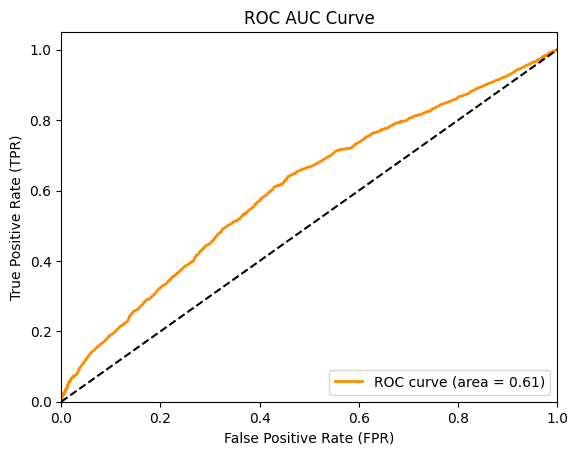

In [ ]:
model_comorbidities_demographics = LogisticRegression(penalty=penalty, C=C, class_weight = "balanced", solver = "liblinear")
model_comorbidities_demographics.fit(X_train_comorbidities_demographics, y_train_comorbidities_demographics)

evaluate_model(model_comorbidities_demographics, X_train_comorbidities_demographics, y_train_comorbidities_demographics, X_test_comorbidities_demographics, y_test_comorbidities_demographics)

In [ ]:
best_features, rfecv_bool = find_best_features(df_imputed[comorbidities_demographics], cv_model, X_train_comorbidities_demographics, y_train_comorbidities_demographics)
print(best_features)

X_train_comorbidities_demographics_rfecv = X_train[:, rfecv_bool]
X_test_comorbidities_demographics_rfecv = X_test[:, rfecv_bool]

Optimal number of features: 11
['Age_at_Exam', 'Sex_01', 'Abnormal_BMI', 'b_R1_sleep', 'b_R1_kidney', 'b_R1_heart', 'b_R1_brain', 'b_R1_eye', '[PVD)', '[Amputation)', '[Anxiety)']


======== Training Set ==========
Confusion Matrix:
[[8062 6465]
 [5574 8953]]

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.55      0.57     14527
           1       0.58      0.62      0.60     14527

    accuracy                           0.59     29054
   macro avg       0.59      0.59      0.59     29054
weighted avg       0.59      0.59      0.59     29054


Accuracy: 0.5856336476905073


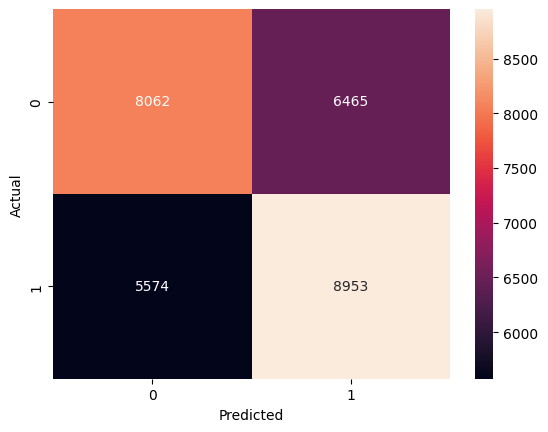

Training AUC: 0.6092


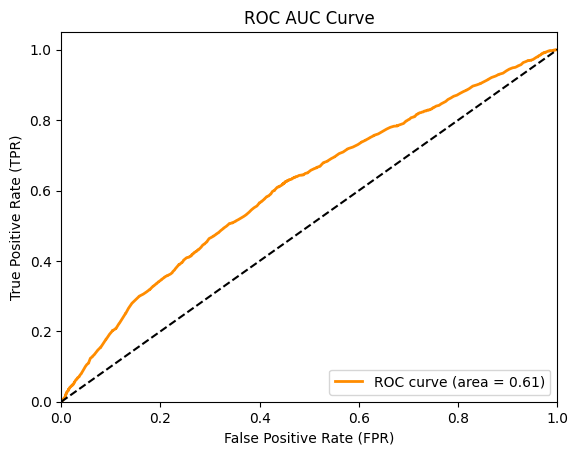

======== Test Set ==========
Confusion Matrix:
[[3514 2704]
 [ 375  598]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.57      0.70      6218
           1       0.18      0.61      0.28       973

    accuracy                           0.57      7191
   macro avg       0.54      0.59      0.49      7191
weighted avg       0.81      0.57      0.64      7191


Accuracy: 0.5718258934779585


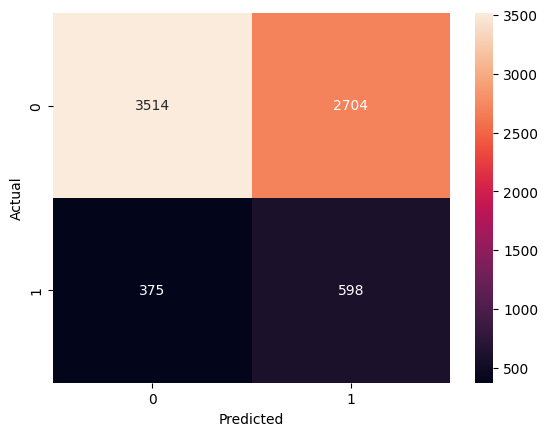

Testing AUC: 0.6073


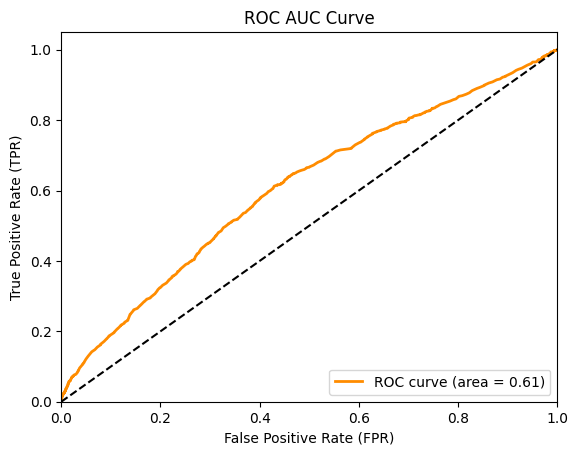

In [ ]:
model_comorbidities_demographics_rfecv = LogisticRegression(penalty=penalty, C=C, class_weight = "balanced", solver = "liblinear")
model_comorbidities_demographics_rfecv.fit(X_train_comorbidities_demographics_rfecv, y_train_comorbidities_demographics)

evaluate_model(model_comorbidities_demographics_rfecv, X_train_comorbidities_demographics_rfecv, y_train_comorbidities_demographics, X_test_comorbidities_demographics_rfecv, y_test_comorbidities_demographics)

## Domain 2: Factors complicating diabetes management

In [ ]:
complications = ['total_b_R1_[1stlineantidiabetic]_Records', 'total_b_R1_[2ndline-antidiabetic]_Records', 'Abnormal_A1c']

X_complications = df_imputed[complications]
y = df_imputed["Depression"]

X_train_complications, X_test_complications, y_train_complications, y_test_complications = impute_and_transform(df_imputed, complications, "Depression", impute = True, smote = True)

cv_model = LogisticRegression(solver = "liblinear")
param_grid = {"C": [0.05, 0.075, 0.0775, 0.08, 0.085, 0.1, 0.15, 0.2, 1, 10, 100],
              "penalty": ["l1", "l2"]}

best_params = find_best_params(cv_model, param_grid, X_train_complications, y_train_complications)
print(best_params)

C = best_params["C"]
penalty = best_params["penalty"]

{'C': 0.05, 'penalty': 'l2'}


======== Training Set ==========
Confusion Matrix:
[[10693  3834]
 [ 9383  5144]]

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.74      0.62     14527
           1       0.57      0.35      0.44     14527

    accuracy                           0.55     29054
   macro avg       0.55      0.55      0.53     29054
weighted avg       0.55      0.55      0.53     29054


Accuracy: 0.5450884559785227


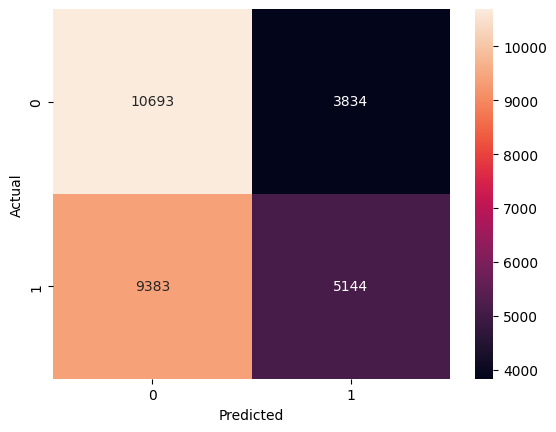

Training AUC: 0.5614


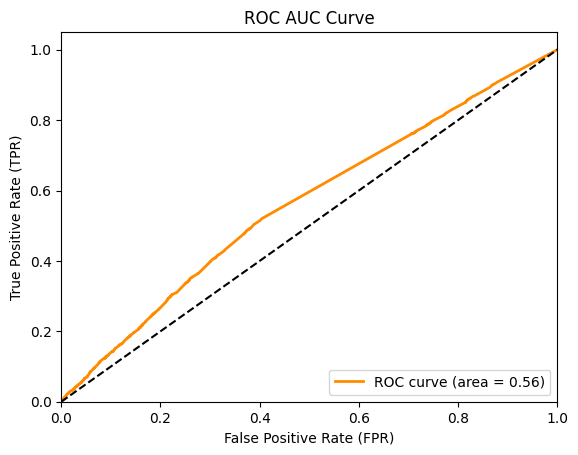

======== Test Set ==========
Confusion Matrix:
[[4602 1616]
 [ 627  346]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      6218
           1       0.18      0.36      0.24       973

    accuracy                           0.69      7191
   macro avg       0.53      0.55      0.52      7191
weighted avg       0.78      0.69      0.73      7191


Accuracy: 0.688082325128633


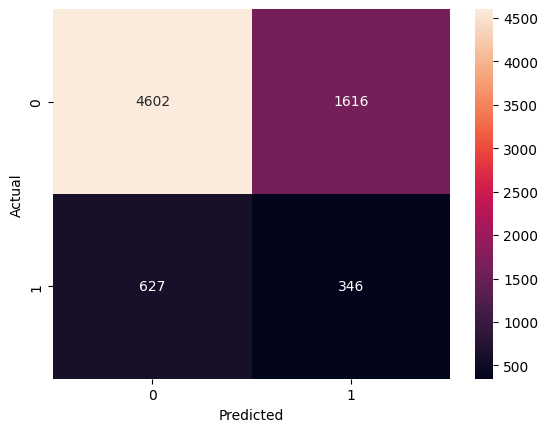

Testing AUC: 0.5665


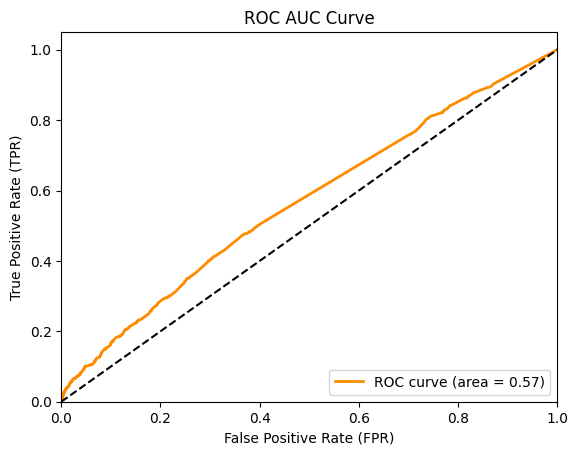

In [ ]:
model_complications = LogisticRegression(penalty=penalty, C=C, class_weight = "balanced", solver = "liblinear")
model_complications.fit(X_train_complications, y_train_complications)

evaluate_model(model_complications, X_train_complications, y_train_complications, X_test_complications, y_test_complications)

In [ ]:
best_features, rfecv_bool = find_best_features(df_imputed[complications], cv_model, X_train_complications, y_train_complications)
print(best_features)

X_train_complications_rfecv = X_train_complications[:, rfecv_bool]
X_test_complications_rfecv = X_test_complications[:, rfecv_bool]

Optimal number of features: 3
['total_b_R1_[1stlineantidiabetic]_Records', 'total_b_R1_[2ndline-antidiabetic]_Records', 'Abnormal_A1c']


======== Training Set ==========
Confusion Matrix:
[[10693  3834]
 [ 9383  5144]]

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.74      0.62     14527
           1       0.57      0.35      0.44     14527

    accuracy                           0.55     29054
   macro avg       0.55      0.55      0.53     29054
weighted avg       0.55      0.55      0.53     29054


Accuracy: 0.5450884559785227


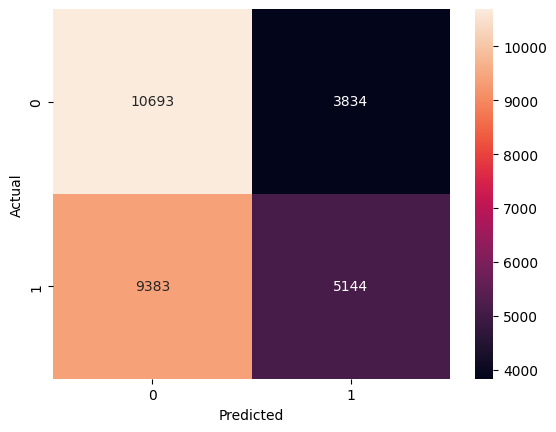

Training AUC: 0.5614


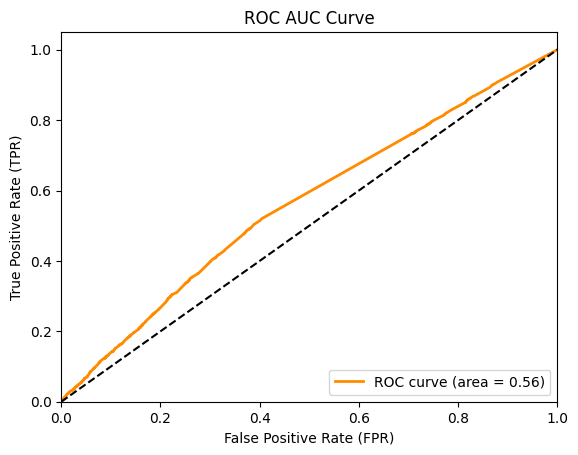

======== Test Set ==========
Confusion Matrix:
[[4602 1616]
 [ 627  346]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      6218
           1       0.18      0.36      0.24       973

    accuracy                           0.69      7191
   macro avg       0.53      0.55      0.52      7191
weighted avg       0.78      0.69      0.73      7191


Accuracy: 0.688082325128633


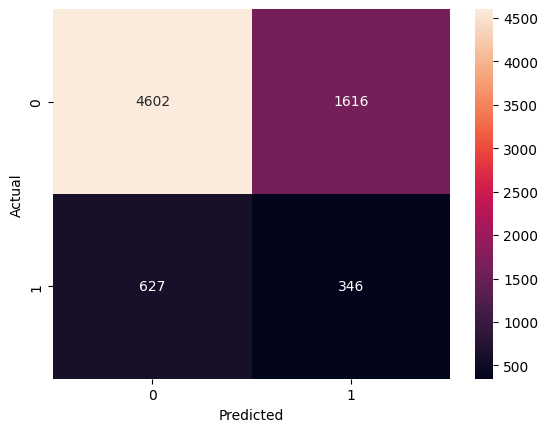

Testing AUC: 0.5665


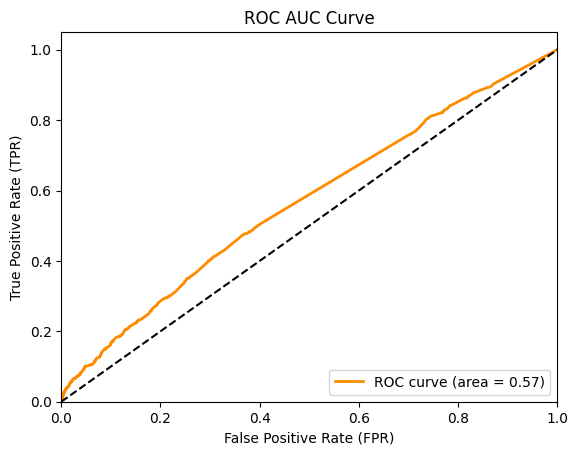

In [ ]:
model_complications_rfecv = LogisticRegression(penalty=penalty, C=C, class_weight = "balanced", solver = "liblinear")
model_complications_rfecv.fit(X_train_complications_rfecv, y_train_complications)

evaluate_model(model_complications_rfecv, X_train_complications_rfecv, y_train_complications, X_test_complications_rfecv, y_test_complications)

## Domain 2a: Factors complicating diabetes management with sociodemographic characteristics

In [ ]:
complications_demographics = ['total_b_R1_[1stlineantidiabetic]_Records', 'total_b_R1_[2ndline-antidiabetic]_Records',
                              'Abnormal_A1c', 'Age_at_Exam', 'Sex_01']

X_complications_demographics = df_imputed[complications_demographics]
y = df_imputed["Depression"]

X_train_complications_demographics, X_test_complications_demographics, y_train_complications_demographics, y_test_complications_demographics = impute_and_transform(df_imputed, complications_demographics, "Depression")

cv_model = LogisticRegression(solver = "liblinear")
param_grid = {"C": [0.05, 0.075, 0.0775, 0.08, 0.085, 0.1, 0.15, 0.2, 1, 10, 100],
              "penalty": ["l1", "l2"]}

best_params = find_best_params(cv_model, param_grid, X_train_complications_demographics, y_train_complications_demographics)
print(best_params)

C = best_params["C"]
penalty = best_params["penalty"]

{'C': 0.05, 'penalty': 'l2'}


======== Training Set ==========
Confusion Matrix:
[[7795 6732]
 [ 830 1422]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.54      0.67     14527
           1       0.17      0.63      0.27      2252

    accuracy                           0.55     16779
   macro avg       0.54      0.58      0.47     16779
weighted avg       0.81      0.55      0.62     16779


Accuracy: 0.5493175993801777


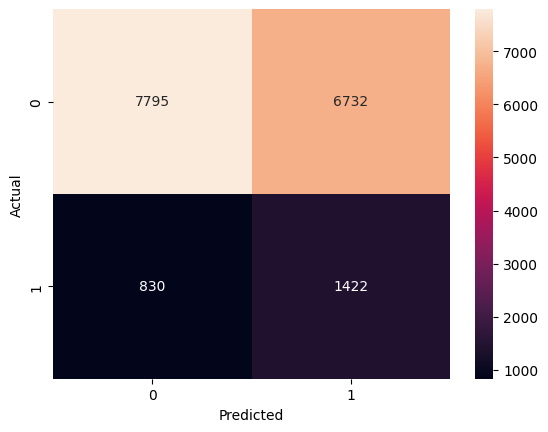

Training AUC: 0.6093


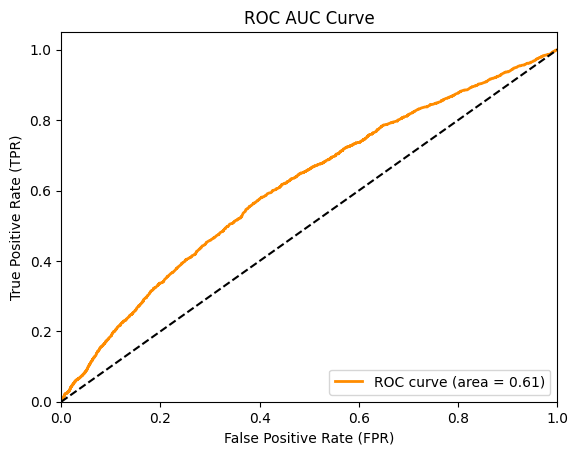

======== Test Set ==========
Confusion Matrix:
[[3403 2815]
 [ 377  596]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.55      0.68      6218
           1       0.17      0.61      0.27       973

    accuracy                           0.56      7191
   macro avg       0.54      0.58      0.48      7191
weighted avg       0.80      0.56      0.63      7191


Accuracy: 0.5561118064246975


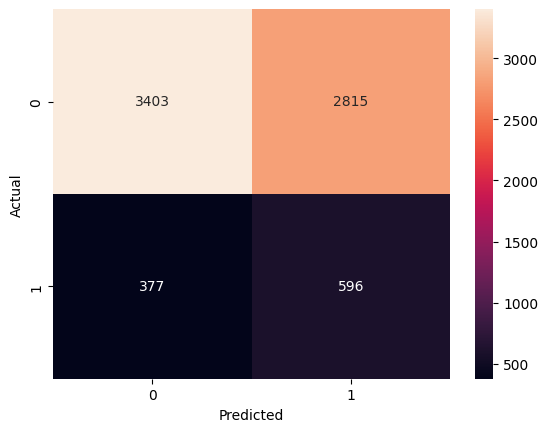

Testing AUC: 0.6182


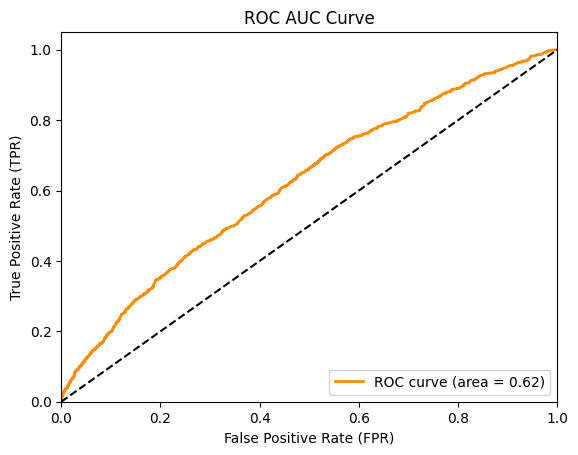

In [ ]:
model_complications_demographics = LogisticRegression(penalty=penalty, C=C, class_weight = "balanced", solver = "liblinear")
model_complications_demographics.fit(X_train_complications_demographics, y_train_complications_demographics)

evaluate_model(model_complications_demographics, X_train_complications_demographics, y_train_complications_demographics, X_test_complications_demographics, y_test_complications_demographics)

In [ ]:
best_features, rfecv_bool = find_best_features(df_imputed[complications_demographics], cv_model, X_train_complications_demographics, y_train_complications_demographics)
print(best_features)

X_train_complications_demographics_rfecv = X_train_complications_demographics[:, rfecv_bool]
X_test_complications_demographics_rfecv = X_test_complications_demographics[:, rfecv_bool]

Optimal number of features: 5
['total_b_R1_[1stlineantidiabetic]_Records', 'total_b_R1_[2ndline-antidiabetic]_Records', 'Abnormal_A1c', 'Age_at_Exam', 'Sex_01']


======== Training Set ==========
Confusion Matrix:
[[7795 6732]
 [ 830 1422]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.54      0.67     14527
           1       0.17      0.63      0.27      2252

    accuracy                           0.55     16779
   macro avg       0.54      0.58      0.47     16779
weighted avg       0.81      0.55      0.62     16779


Accuracy: 0.5493175993801777


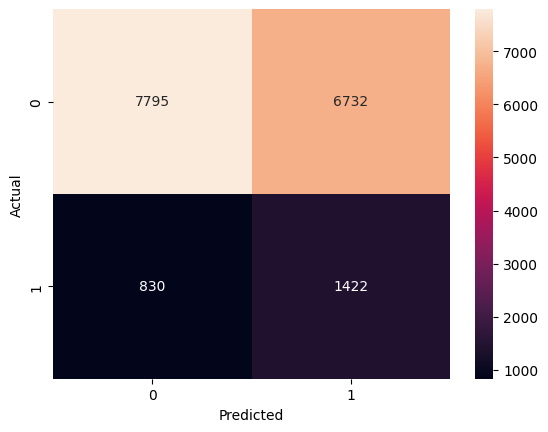

Training AUC: 0.6093


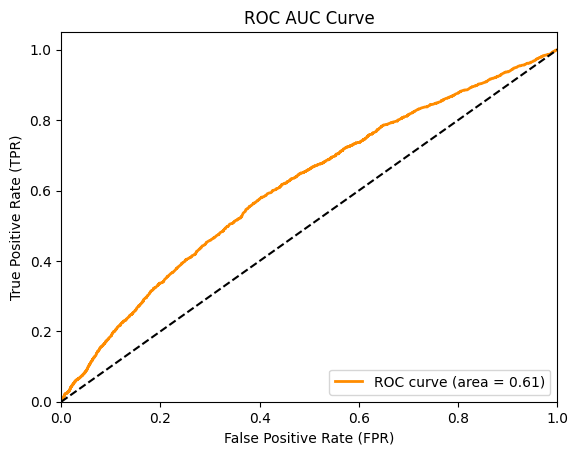

======== Test Set ==========
Confusion Matrix:
[[3403 2815]
 [ 377  596]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.55      0.68      6218
           1       0.17      0.61      0.27       973

    accuracy                           0.56      7191
   macro avg       0.54      0.58      0.48      7191
weighted avg       0.80      0.56      0.63      7191


Accuracy: 0.5561118064246975


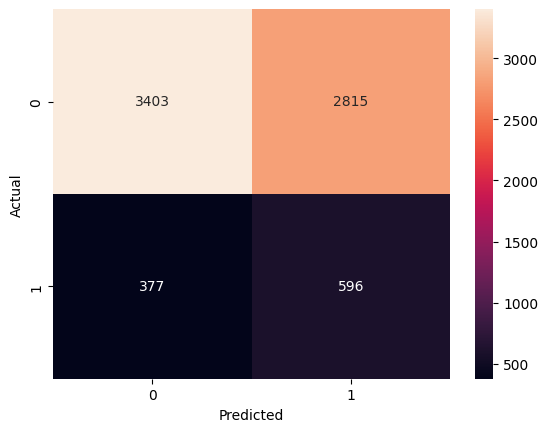

Testing AUC: 0.6182


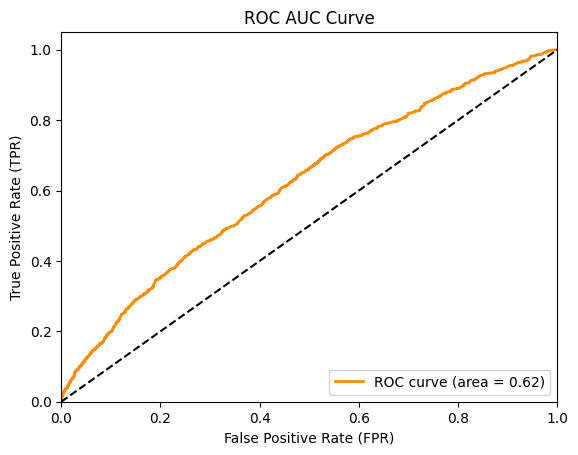

In [ ]:
model_complications_demographics_rfecv = LogisticRegression(penalty=penalty, C=C, class_weight = "balanced", solver = "liblinear")
model_complications_demographics_rfecv.fit(X_train_complications_demographics_rfecv, y_train_complications_demographics)

evaluate_model(model_complications_demographics_rfecv, X_train_complications_demographics_rfecv, y_train_complications_demographics, X_test_complications_demographics_rfecv, y_test_complications_demographics)

## Combining domains 1 and 2 (i.e., all features)

In [ ]:
all = comorbidities + complications + ["Age_at_Exam", "Sex_01"]

X_all = df_imputed[all]
y = df_imputed["Depression"]

X_train_all, X_test_all, y_train_all, y_test_all = impute_and_transform(df_imputed, all, "Depression", impute = True, smote = True)

cv_model = LogisticRegression(solver = "liblinear")
param_grid = {"C": [0.05, 0.075, 0.0775, 0.08, 0.085, 0.1, 0.15, 0.2, 1, 10, 100],
              "penalty": ["l1", "l2"]}

best_params = find_best_params(cv_model, param_grid, X_train_all, y_train_all)
print(best_params)

C = best_params["C"]
penalty = best_params["penalty"]

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'C': 0.2, 'penalty': 'l1'}


======== Training Set ==========
Confusion Matrix:
[[8154 6373]
 [5299 9228]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.56      0.58     14527
           1       0.59      0.64      0.61     14527

    accuracy                           0.60     29054
   macro avg       0.60      0.60      0.60     29054
weighted avg       0.60      0.60      0.60     29054


Accuracy: 0.5982652990982309


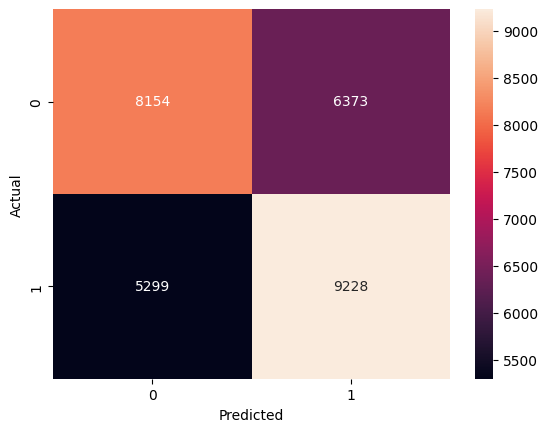

Training AUC: 0.6291


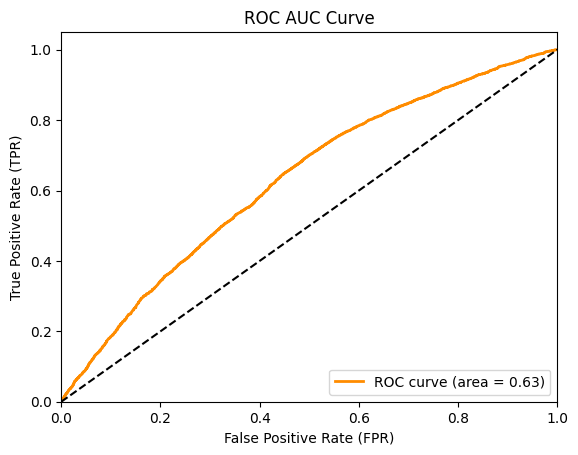

======== Test Set ==========
Confusion Matrix:
[[3578 2640]
 [ 377  596]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.58      0.70      6218
           1       0.18      0.61      0.28       973

    accuracy                           0.58      7191
   macro avg       0.54      0.59      0.49      7191
weighted avg       0.81      0.58      0.65      7191


Accuracy: 0.5804477819496593


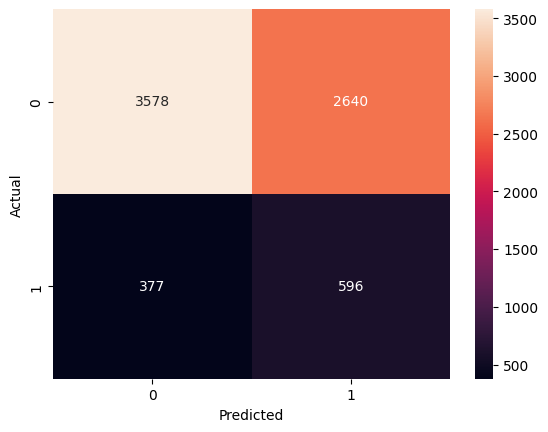

Testing AUC: 0.6260


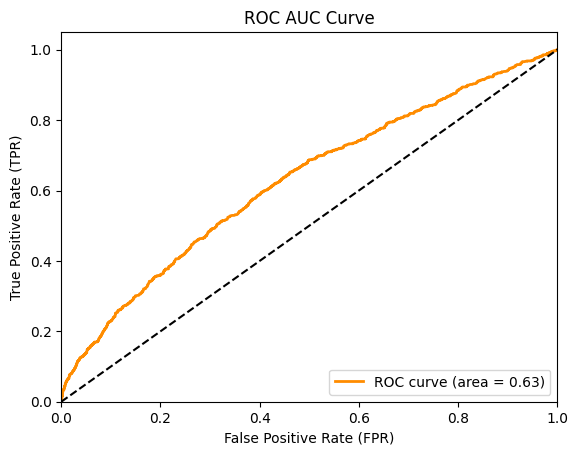

In [ ]:
model_all = LogisticRegression(penalty=penalty, C=C, class_weight = "balanced", solver = "liblinear")
model_all.fit(X_train_all, y_train_all)

evaluate_model(model_all, X_train_all, y_train_all, X_test_all, y_test_all)

In [ ]:
best_features, rfecv_bool = find_best_features(df_imputed[all], cv_model, X_train_all, y_train_all)
print(best_features)

X_train_all_rfecv = X_train_all[:, rfecv_bool]
X_test_all_rfecv = X_test_all[:, rfecv_bool]

Optimal number of features: 15
['Abnormal_BMI', 'b_R1_sleep', 'b_R1_kidney', 'b_R1_heart', 'b_R1_brain', 'b_R1_eye', '[PVD)', '[Amputation)', '[Anxiety)', '[RetinalTear)', 'total_b_R1_[1stlineantidiabetic]_Records', 'total_b_R1_[2ndline-antidiabetic]_Records', 'Abnormal_A1c', 'Age_at_Exam', 'Sex_01']


======== Training Set ==========
Confusion Matrix:
[[8162 6365]
 [5313 9214]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.56      0.58     14527
           1       0.59      0.63      0.61     14527

    accuracy                           0.60     29054
   macro avg       0.60      0.60      0.60     29054
weighted avg       0.60      0.60      0.60     29054


Accuracy: 0.5980587870861155


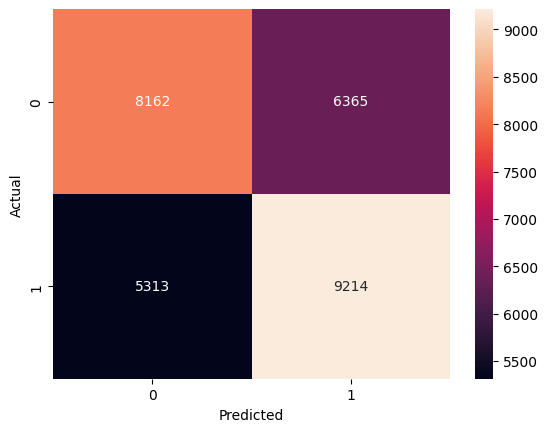

Training AUC: 0.6290


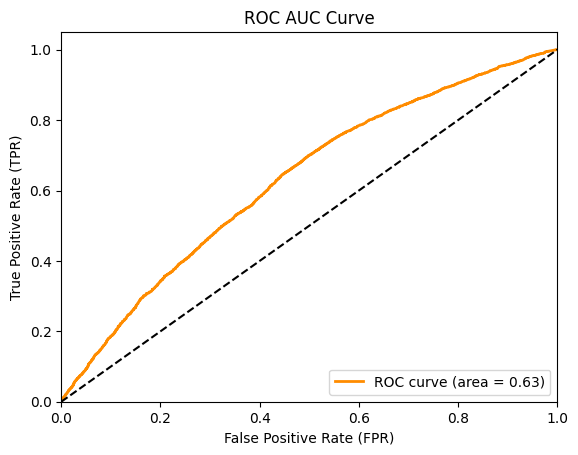

======== Test Set ==========
Confusion Matrix:
[[3586 2632]
 [ 376  597]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.58      0.70      6218
           1       0.18      0.61      0.28       973

    accuracy                           0.58      7191
   macro avg       0.54      0.60      0.49      7191
weighted avg       0.81      0.58      0.65      7191


Accuracy: 0.5816993464052288


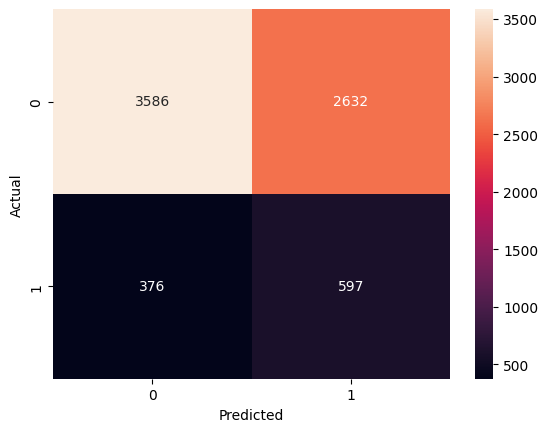

Testing AUC: 0.6273


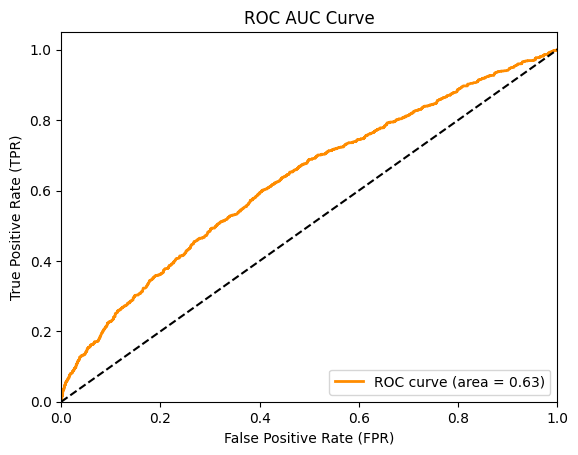

In [ ]:
model_all_rfecv = LogisticRegression(penalty=penalty, C=C, class_weight = "balanced", solver = "liblinear")
model_all_rfecv.fit(X_train_all_rfecv, y_train_all)

evaluate_model(model_all_rfecv, X_train_all_rfecv, y_train_all, X_test_all_rfecv, y_test_all)